In [ ]:
# 한글폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# 라이브러리 불러오기 및 기타설정


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
import seaborn as sns

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{: .0f}'.format

import warnings  
warnings.filterwarnings('ignore')

In [ ]:
# 제공된 약국 POS 데이터 불러오기
data_2020q1 = pd.read_csv('/content/drive/MyDrive/data_visaulization/2020q1.csv')
data_2020q2 = pd.read_csv('/content/drive/MyDrive/data_visaulization/2020q2.csv')
data_2020q3 = pd.read_csv('/content/drive/MyDrive/data_visaulization/2020q3.csv')
data_2020q4 = pd.read_csv('/content/drive/MyDrive/data_visaulization/2020q4.csv')

data_2021q1 = pd.read_csv('/content/drive/MyDrive/data_visaulization/2021q1.csv', encoding = 'CP949')
data_2021q2 = pd.read_csv('/content/drive/MyDrive/data_visaulization/2021q2.csv', encoding = 'CP949')
data_2021q3 = pd.read_csv('/content/drive/MyDrive/data_visaulization/2021q3.csv', encoding = 'CP949')

In [ ]:
# 분석을 위해 데이터 합치기
data = pd.concat([data_2020q1,data_2020q2,data_2020q3,data_2020q4,data_2021q1,data_2021q2,data_2021q3])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8412838 entries, 0 to 799105
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   거래일자           int64  
 1   우편번호           int64  
 2   시도명            object 
 3   시군구명           object 
 4   읍면동명           object 
 5   상품명            object 
 6   온누리상품대분류카테고리명  object 
 7   온누리상품중분류카테고리명  object 
 8   온누리상품소분류카테고리명  object 
 9   상품판매수량         int64  
 10  상품판매금액         int64  
 11  제품명            object 
 12  상품판매단가         float64
dtypes: float64(1), int64(4), object(8)
memory usage: 898.6+ MB


- 기본전처리

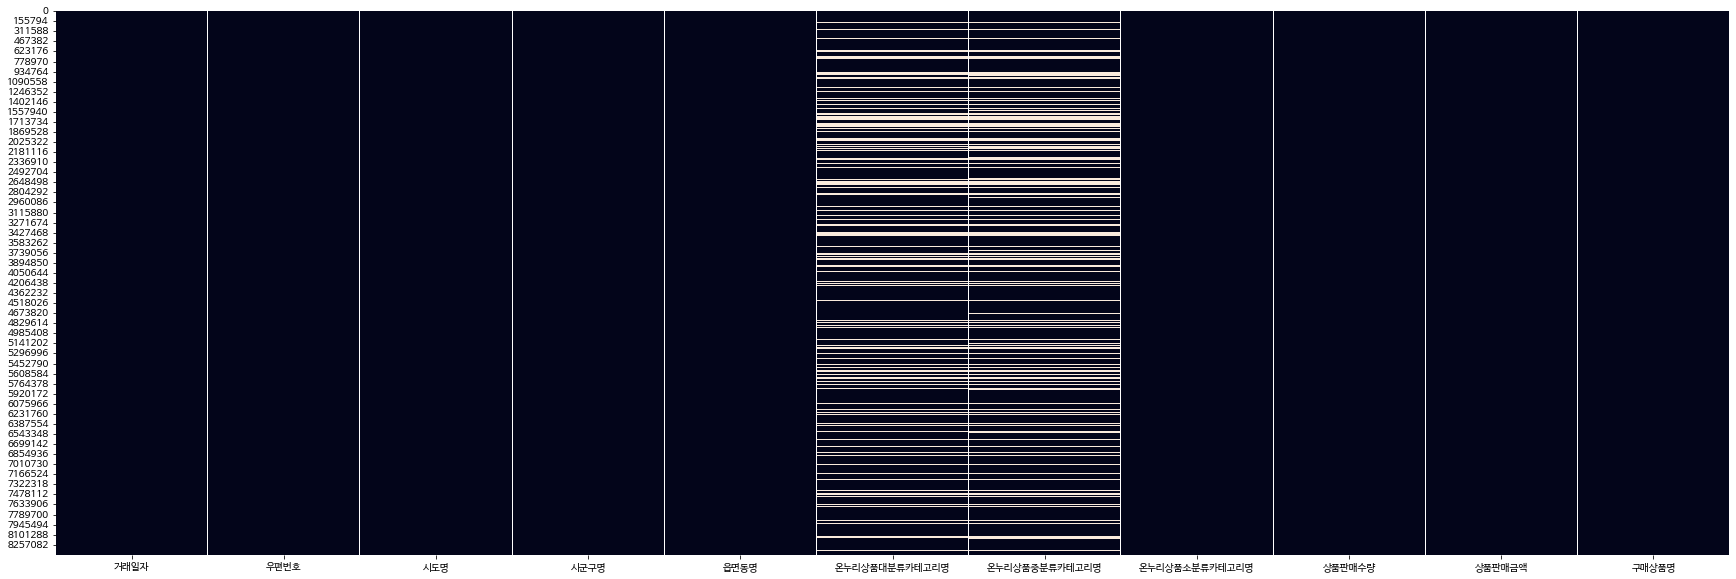

In [ ]:
# 결측치 확인
plt.figure(figsize = (30,10))  
sns.heatmap(data.isnull(), cbar=False)

In [ ]:
# 코로나 일별 확진자 데이터 가져오기
corona = pd.read_excel('/content/drive/MyDrive/data_visaulization/일별확진데이터.xlsx', names= ['거래일자', '확진자수'])

dates = pd.date_range('2020-01-01','2020-02-01',freq='D') 
c_add = pd.Series(dates, name = '거래일자').to_frame()
c_add['확진자수'] = 0

corona = pd.concat([c_add, corona])

corona['거래일자_주']= corona['거래일자'].dt.to_period('W').apply(lambda r: r.start_time)
corona = corona.reset_index(drop=True)

corona = corona.iloc[:639, :]

In [ ]:
# 데이터 전처리 1 : 상품명 또는 제품명을 구매상품명으로 통일
data["제품명"] = data["제품명"].fillna("")
data["상품명"] = data["상품명"].fillna("")
data["구매상품명"] = data["상품명"] + data["제품명"]

data = data.drop(columns = ['상품판매단가','제품명', '상품명'])
data = data.reset_index(drop=True)

In [ ]:
# 컬럼별 유니크 변수값 확인
def num_unique(column) :
  temp = data[column].nunique()
  print("{} : {}".format(column, temp))

for i in data.columns :
  num_unique(i)

거래일자 : 626
우편번호 : 114
시도명 : 11
시군구명 : 67
읍면동명 : 112
온누리상품대분류카테고리명 : 20
온누리상품중분류카테고리명 : 110
온누리상품소분류카테고리명 : 276
상품판매수량 : 547
상품판매금액 : 5289
구매상품명 : 28908


In [ ]:
data['온누리상품대분류카테고리명'].unique()

array(['일반의약품 ', nan, '헬스(일부 카테고리에 일반의약품 포함) ', '뷰티 ', '리빙 ', '퍼스널케어 ',
       '헬스 ', '기타 ', '헬스(일부 카테고리에 일반의약품 포함) 한방건재 ',
       '헬스(일부 카테고리에 일반의약품 포함) 의료기기/용품및운동기구 ', '헬스(일부 일반의약품/건기기식 포함) ',
       '헬스(일부 카테고리에 일반의약품 포함)', '리빙', '일반의약품', '퍼스널케어', '뷰티', '기타', '헬스',
       '헬스(일부 일반의약품/건기기식 포함)', '헬스(일부 카테고리에 일반의약품 포함) 한방건재',
       '헬스(일부 카테고리에 일반의약품 포함) 의료기기/용품및운동기구'], dtype=object)

In [ ]:
# 데이터값 전처리 2 : 대분류카테고리 공백제거
data['온누리상품대분류카테고리명'] = data['온누리상품대분류카테고리명'].astype(str).apply(lambda x : x.rstrip())

# 데이터값 전처리 3 : 대분류카테고리 헬스분류
def processing(i) :
  if i[:2] == "헬스" :
    return "헬스"
  else : return i

data['온누리상품대분류카테고리명'] = data['온누리상품대분류카테고리명'].apply(lambda x : processing(x))

# 데이터값 전처리 4 : 대분류카테고리 결측치를 기타로
data['온누리상품대분류카테고리명'] = data['온누리상품대분류카테고리명'].replace('nan', '기타')

In [ ]:
data['온누리상품대분류카테고리명'].unique()

array(['일반의약품', '기타', '헬스', '뷰티', '리빙', '퍼스널케어'], dtype=object)

In [ ]:
data['온누리상품소분류카테고리명'].unique()

array(['목감기', '통증·염증', '해열·진통', '미분류상품', '상처드레싱·밴드', '종합감기', '포진',
       '코감기/알레르기', '숙취해소', '간건강', '근이완', '아미노산/효모/클로렐라', '핫팩·찜질팩·기기',
       '자양강장 고농축앰플제', '종합비타민/비타민B/비타민C', '마스크', '멀미/구충', '설사', '위장',
       '면봉/화장솜/기름종이', '소독용품', '소화', '기타', '청심원/천왕보심단', '혈당계 및 용품',
       '일회용주사기', '국소진통완화', '감기/쌍화탕', '인공눈물', '트러블/여드름/손상케어', '립케어', '가글',
       '헬시푸드', '음료·차·즙', '관절보호대', '금연보조', '치간칫솔/치실', '발모·탈모방지', '신경·순환기계',
       '무좀·진균', '베타카로틴/비타민E/셀레늄', '어린이비타민', '발·다리 보습', '로션/크림/오일',
       '해충·방충·모기기피제', '화상', '벌레물린데·가려운데', '콘텍트렌즈용품', '상처/흉터', '소염',
       '마그네슘', '비듬·지루성피부', '잇몸건강', '여드름/기미', '여성청결·질정', '어린이 해열·진통',
       '습진·피부염', '유산균', '치약', '소화기·설사·변비·치질', '오메가3', '국소진통완화제',
       '빈혈·어지러움', '당뇨·혈당건강', '피임약', '러브젤', '피로·충혈', '장청소', '피부·알레르기',
       '변비', '동물의약품', '뼈건강/비타민D', '페이셜용품', '콘돔', '국소마취', '남성케어', '임신테스트',
       '새치커버 염모제', '토너/로션/크림/미스트', '식이섬유', '치질', '칫솔', '귀관리용품',
       '마사지/교정/운동용품', '틀니케어', '면역증진', '수면유도', '비뇨·생식기', '생리대',
       '보습/아토피 케어', '루테인', '관절건강', '네일

In [ ]:
# 전처리 추가 카테고리 테이블 작성

item = data.groupby(by=['온누리상품대분류카테고리명', '온누리상품소분류카테고리명'])['상품판매금액'].sum().reset_index()
item = item.sort_values(by=['온누리상품대분류카테고리명','상품판매금액'], ascending=[False, False]).reset_index(drop=True)

a = item[ item['온누리상품대분류카테고리명'] == '헬스' ][['온누리상품대분류카테고리명', '온누리상품소분류카테고리명']].head(5)
b = item[ item['온누리상품대분류카테고리명'] == '퍼스널케어' ][['온누리상품대분류카테고리명', '온누리상품소분류카테고리명']].head(5)
c = item[ item['온누리상품대분류카테고리명'] == '일반의약품' ][['온누리상품대분류카테고리명', '온누리상품소분류카테고리명']].head(5)
d = item[ item['온누리상품대분류카테고리명'] == '뷰티' ][['온누리상품대분류카테고리명', '온누리상품소분류카테고리명']].head(5)
e = item[ item['온누리상품대분류카테고리명'] == '리빙' ][['온누리상품대분류카테고리명', '온누리상품소분류카테고리명']].head(5)

item_show = pd.concat([a, b, c, d, e])
item_show.reset_index(drop=True)

온누리상품대분류카테고리명    온누리상품소분류카테고리명
0             헬스  종합비타민/비타민B/비타민C
1             헬스              마스크
2             헬스             잇몸건강
3             헬스         상처드레싱·밴드
4             헬스              유산균
5          퍼스널케어          발모·탈모방지
6          퍼스널케어         새치커버 염모제
7          퍼스널케어               치약
8          퍼스널케어        핸드워시/손소독제
9          퍼스널케어          치간칫솔/치실
10         일반의약품           국소진통완화
11         일반의약품            해열·진통
12         일반의약품               소화
13         일반의약품             종합감기
14         일반의약품         코감기/알레르기
15            뷰티     트러블/여드름/손상케어
16            뷰티              립케어
17            뷰티      면봉/화장솜/기름종이
18            뷰티     토너/로션/크림/미스트
19            뷰티        보습/아토피 케어
20            리빙               기타
21            리빙      해충·방충·모기기피제
22            리빙           음료·차·즙
23            리빙             헬시푸드
24            리빙            동물의약품

In [ ]:
# 전처리 5 : 동아박카스D : 비타민 > 자양강장/피로회복으로 이동
data.loc[data['구매상품명'] == '동아박카스D', '온누리상품소분류카테고리명'] = '자양강장/피로회복'

In [ ]:
# 데이터값 전처리 6 : 거래일자 - 날짜타입로 변환
data['거래일자'] = pd.to_datetime(data['거래일자'], format='%Y%m%d')

In [ ]:
data['거래일자']

0         2020-01-02
1         2020-01-02
2         2020-01-02
3         2020-01-02
4         2020-01-02
             ...    
8412833   2021-09-30
8412834   2021-09-30
8412835   2021-09-30
8412836   2021-09-30
8412837   2021-09-30
Name: 거래일자, Length: 8412838, dtype: datetime64[ns]

In [ ]:
# 데이터값 전처리 7 : 거래일자 - 주별데이터 추가
data['거래일자_주'] = data['거래일자'].dt.to_period('W').apply(lambda r: r.start_time)

In [ ]:
data['거래일자_주']

0         2019-12-30
1         2019-12-30
2         2019-12-30
3         2019-12-30
4         2019-12-30
             ...    
8412833   2021-09-27
8412834   2021-09-27
8412835   2021-09-27
8412836   2021-09-27
8412837   2021-09-27
Name: 거래일자_주, Length: 8412838, dtype: datetime64[ns]

In [ ]:
# 데이터값 전처리 8 : 거래일자 - 월별데이터 추가
data['거래일자_월'] = data['거래일자'].dt.to_period('M')

- 분석시작

In [ ]:
table0 = data.groupby(['거래일자_주','온누리상품대분류카테고리명'])['상품판매금액'].sum().reset_index()
table0['거래일자_주']= table0['거래일자_주'].astype('str')

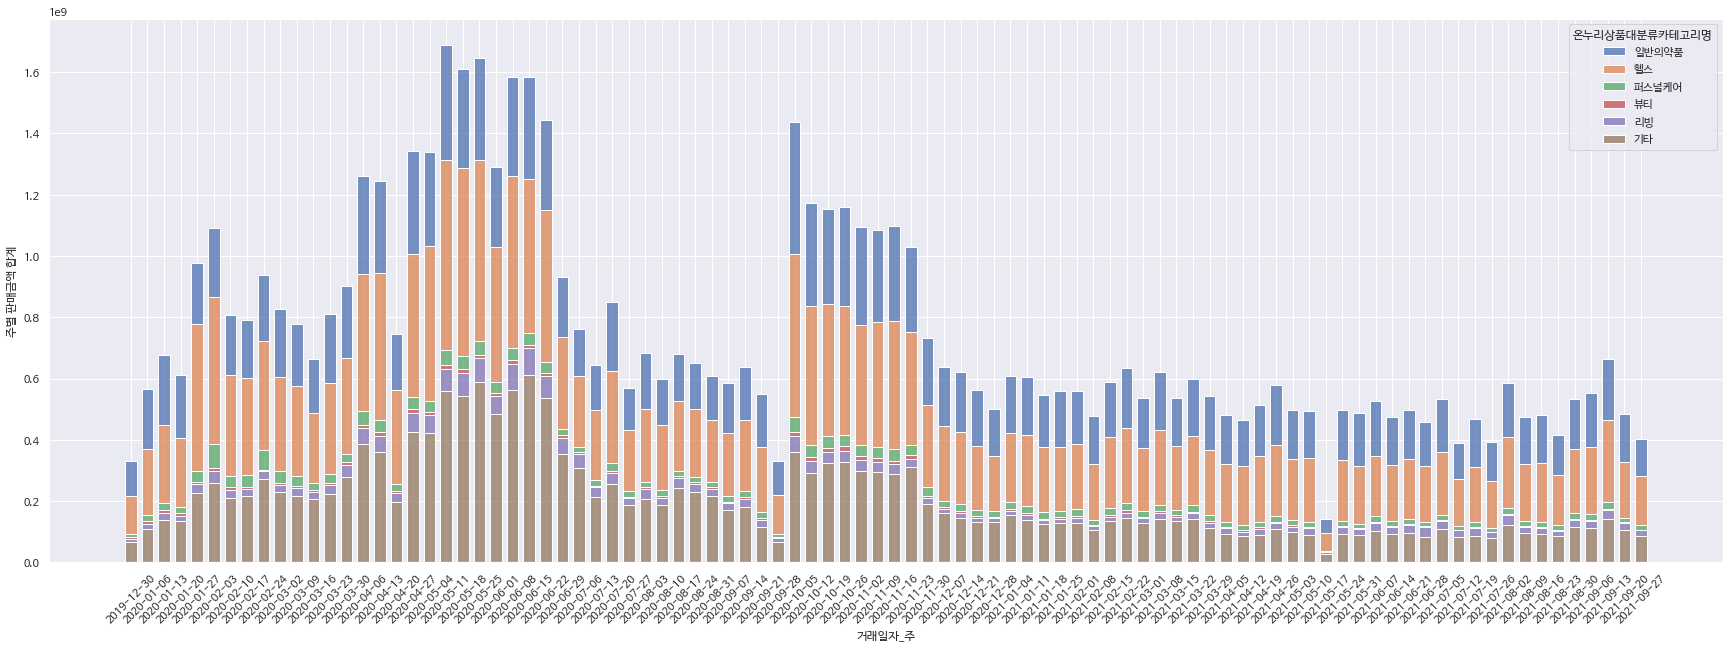

In [ ]:
# 전체매출데이터
plt.figure(figsize = (30,10))
hue_order = ['일반의약품', '헬스', '퍼스널케어', '뷰티', '리빙', '기타']

sns.set(font='NanumBarunGothic', 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

sns.histplot(data=table0, x= '거래일자_주',  weights='상품판매금액', hue='온누리상품대분류카테고리명' , multiple='stack', shrink=0.7, hue_order = hue_order)
plt.xticks(rotation=45)
plt.ylabel('주별 판매금액 합계')
plt.show()

In [ ]:
table0 = data.groupby(['거래일자_주','온누리상품대분류카테고리명'])['판매비중'].sum().reset_index()
table0['거래일자_주']= table0['거래일자_주'].astype('str')

In [ ]:
table0

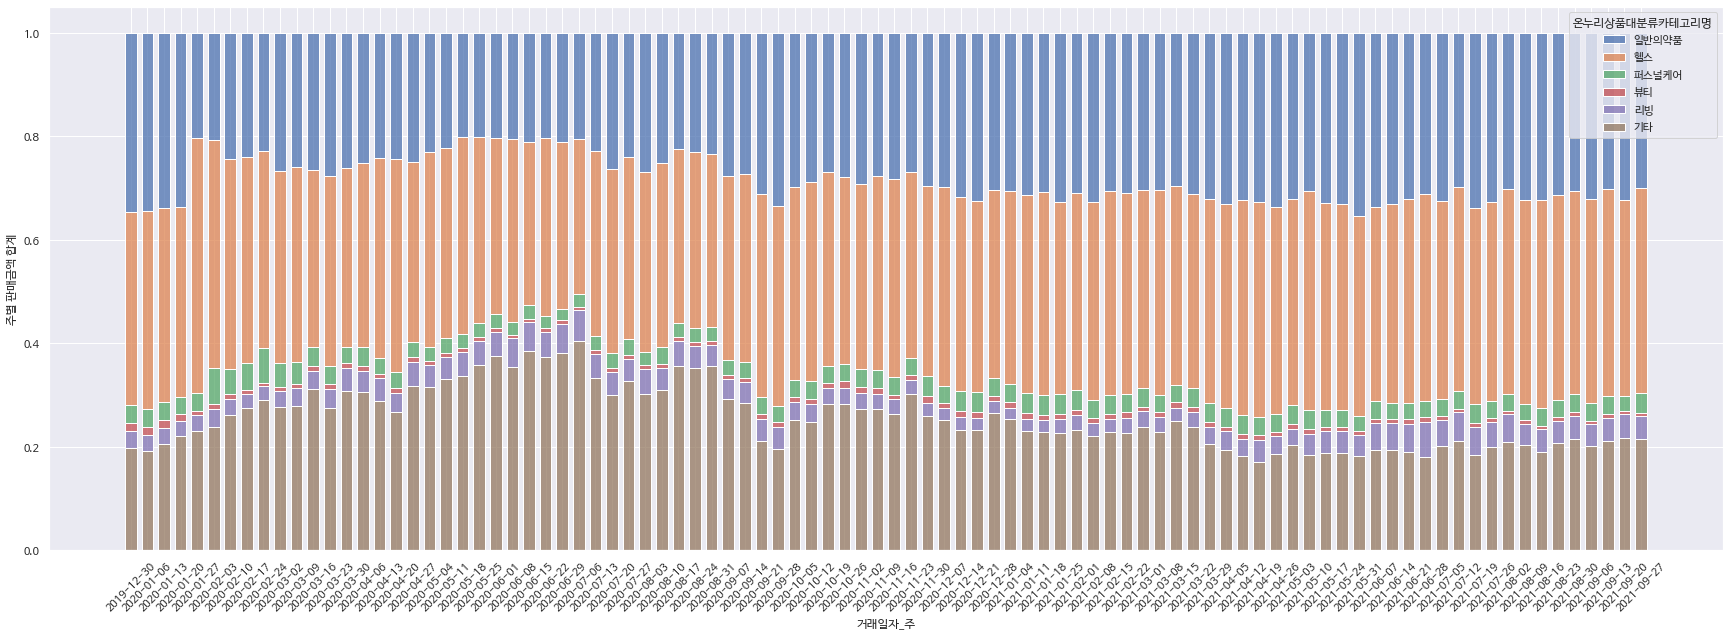

In [ ]:
# 전체매출 비중데이터
plt.figure(figsize = (30,10))
hue_order = ['일반의약품', '헬스', '퍼스널케어', '뷰티', '리빙', '기타']

sns.set(font='NanumBarunGothic', 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

sns.histplot(data=table0, x= '거래일자_주',  weights='판매비중', hue='온누리상품대분류카테고리명' , multiple='stack', shrink=0.7, hue_order = hue_order)
plt.xticks(rotation=45)
plt.ylabel('주별 판매금액 합계')
plt.show()

In [ ]:
# 판매비중 계산
total = data.groupby(by= '거래일자_주')['상품판매금액'].sum().reset_index().rename(columns = {'상품판매금액' : '총판매금액'}) # rename(columns = {'상품판매금액' : '총판매금액'})


data = data.merge(total, on = '거래일자_주')

In [ ]:
data['판매비중'] = data['상품판매금액'] / data['총판매금액']

In [ ]:
table1 = data.groupby(['거래일자_주', '온누리상품소분류카테고리명'])['판매비중'].sum().reset_index()

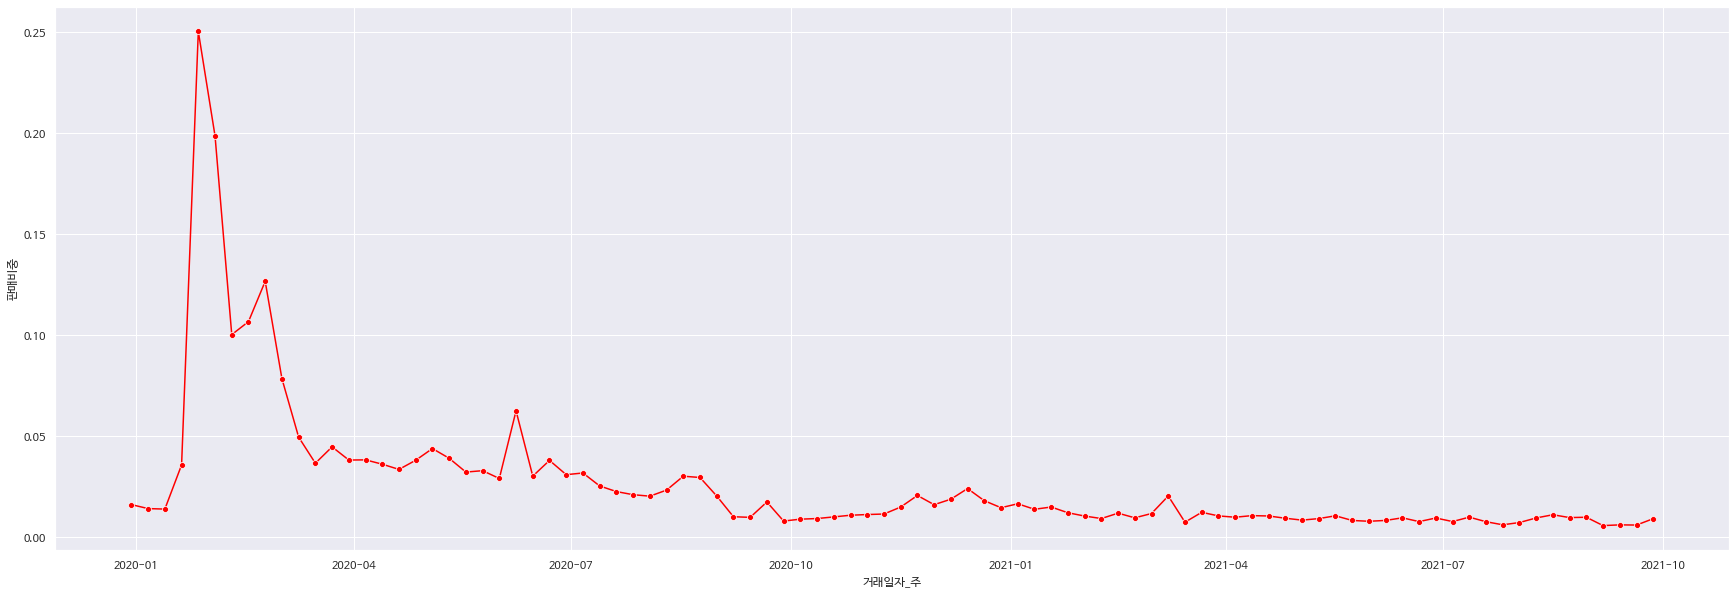

In [ ]:
# 마스크 판매비중 추이
condition = table1[table1['온누리상품소분류카테고리명'] == '마스크']

sns.set(font='NanumBarunGothic', 
        rc={"axes.unicode_minus":False},
        style='darkgrid')
plt.figure(figsize = (30,10))
sns.lineplot(data=condition,  x='거래일자_주', y='판매비중', marker= "o", color = 'red')

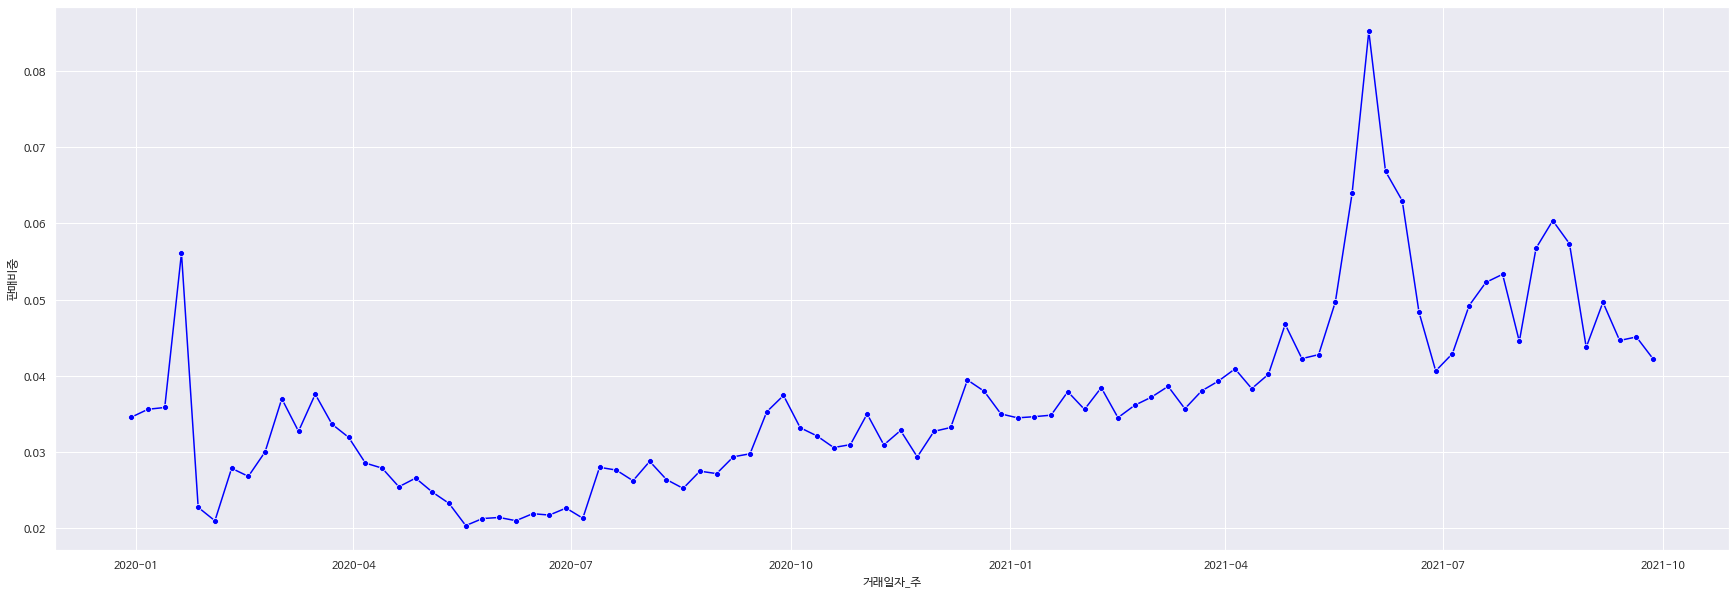

In [ ]:
#  해열·진통제 판매비중 추이
condition = table1[table1['온누리상품소분류카테고리명'] == '해열·진통']

sns.set(font='NanumBarunGothic', 
        rc={"axes.unicode_minus":False},
        style='darkgrid')
plt.figure(figsize = (30,10))
sns.lineplot(data=condition,  x='거래일자_주', y='판매비중', marker= "o", color = 'blue')

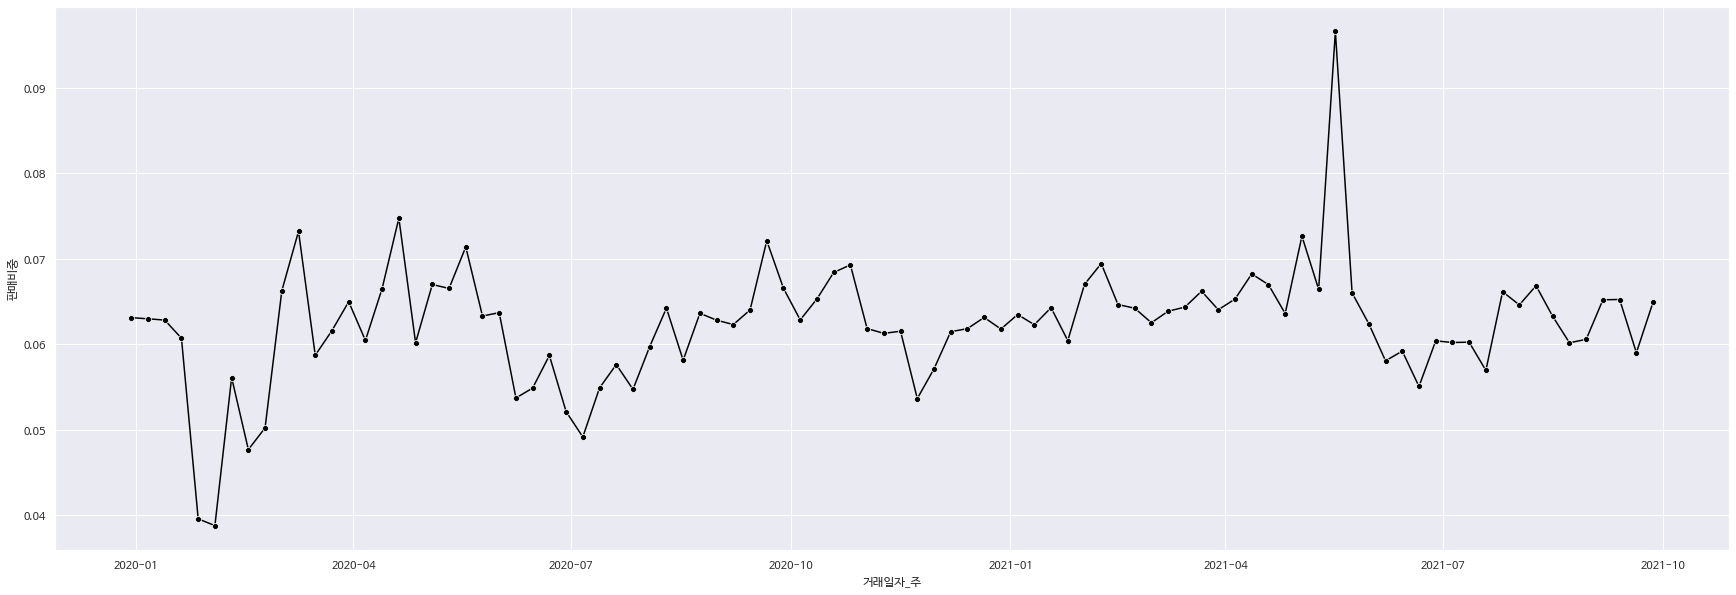

In [ ]:
#  종합비타민/비타민B/비타민C 판매비중 추이
condition = table1[table1['온누리상품소분류카테고리명'] == '종합비타민/비타민B/비타민C']

sns.set(font='NanumBarunGothic', 
        rc={"axes.unicode_minus":False},
        style='darkgrid')
plt.figure(figsize = (30,10))
sns.lineplot(data=condition,  x='거래일자_주', y='판매비중', marker= "o", color = 'black')

# ax2 = plt.twinx()
# sns.lineplot(data = table3, x = '거래일자_주', y = '확진자수', ax=ax2)

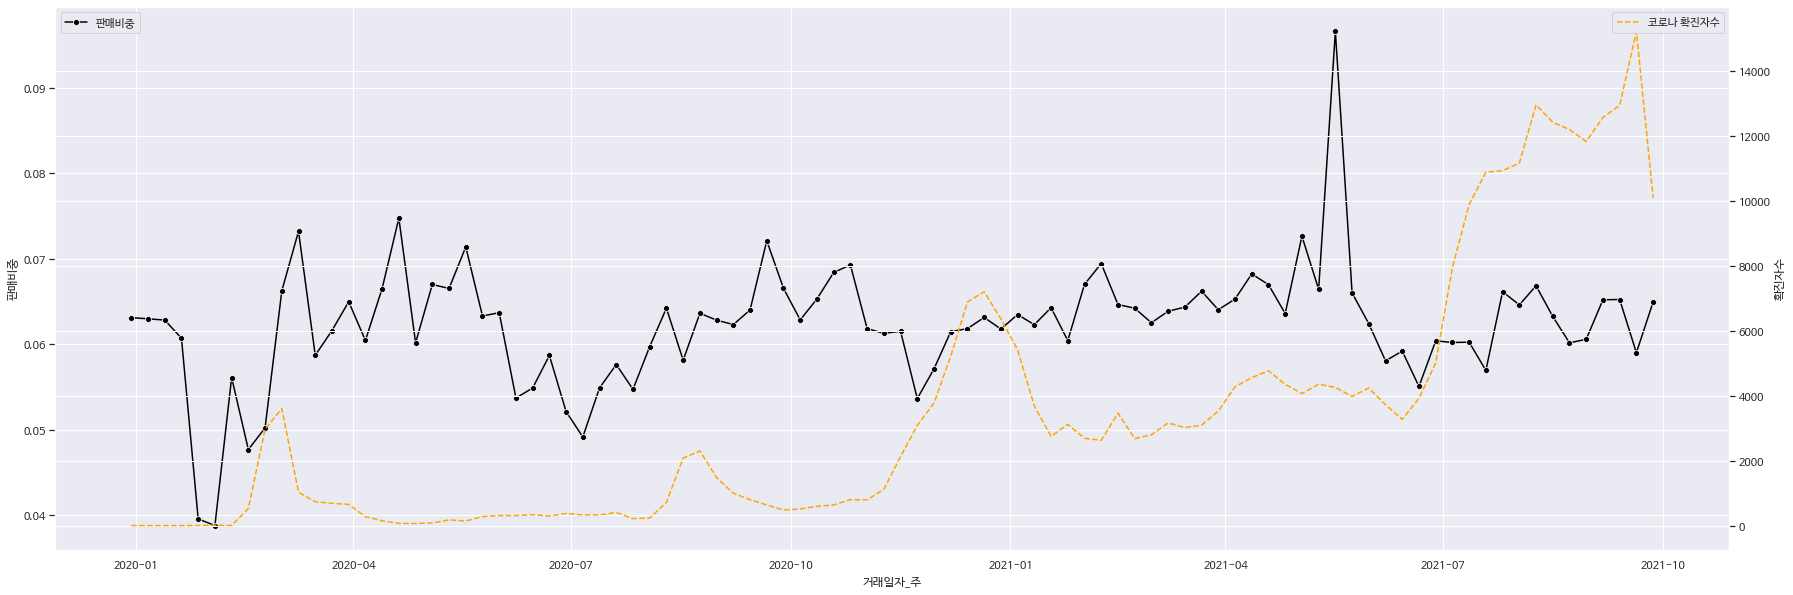

In [ ]:
#  코로나 확진 추이 추가
condition = table1[table1['온누리상품소분류카테고리명'] == '종합비타민/비타민B/비타민C']

sns.set(font='NanumBarunGothic', 
        rc={"axes.unicode_minus":False},
        style='darkgrid')
plt.figure(figsize = (30,10))
sns.lineplot(data=condition,  x='거래일자_주', y='판매비중', marker= "o", color = 'black')
plt.legend(labels=['판매비중'],loc = 2)


table2 = corona.groupby('거래일자_주')['확진자수'].sum().reset_index()

ax2 = plt.twinx()
sns.lineplot(data = table2, x = '거래일자_주', y = '확진자수', color = 'orange', linestyle='--', ax=ax2)

plt.legend(labels=['코로나 확진자수'],loc = 1)

In [ ]:
# 쇼핑트렌드
temp = pd.read_csv('/content/drive/MyDrive/data_visaulization/네이버쇼핑트렌드.csv', sep='delimiter', header=None)

In [ ]:
shopping = pd.DataFrame()
shopping['거래일자_주'] = temp.iloc[8:, 0].apply(lambda x : x.split(',')[0])
shopping['거래일자_주'] = shopping['거래일자_주'].apply(lambda x : x.replace('"', ''))
shopping['거래일자_주'] =  pd.to_datetime(shopping['거래일자_주'])

shopping['쇼핑 검색량'] = temp.iloc[8:, 0].apply(lambda x : x.split(',')[1])
shopping['쇼핑 검색량'] = shopping['쇼핑 검색량'].astype('int')


In [ ]:
shopping.head()

거래일자_주  쇼핑 검색량
8  2020-09-28      35
9  2020-10-05      45
10 2020-10-12      44
11 2020-10-19      42
12 2020-10-26      43

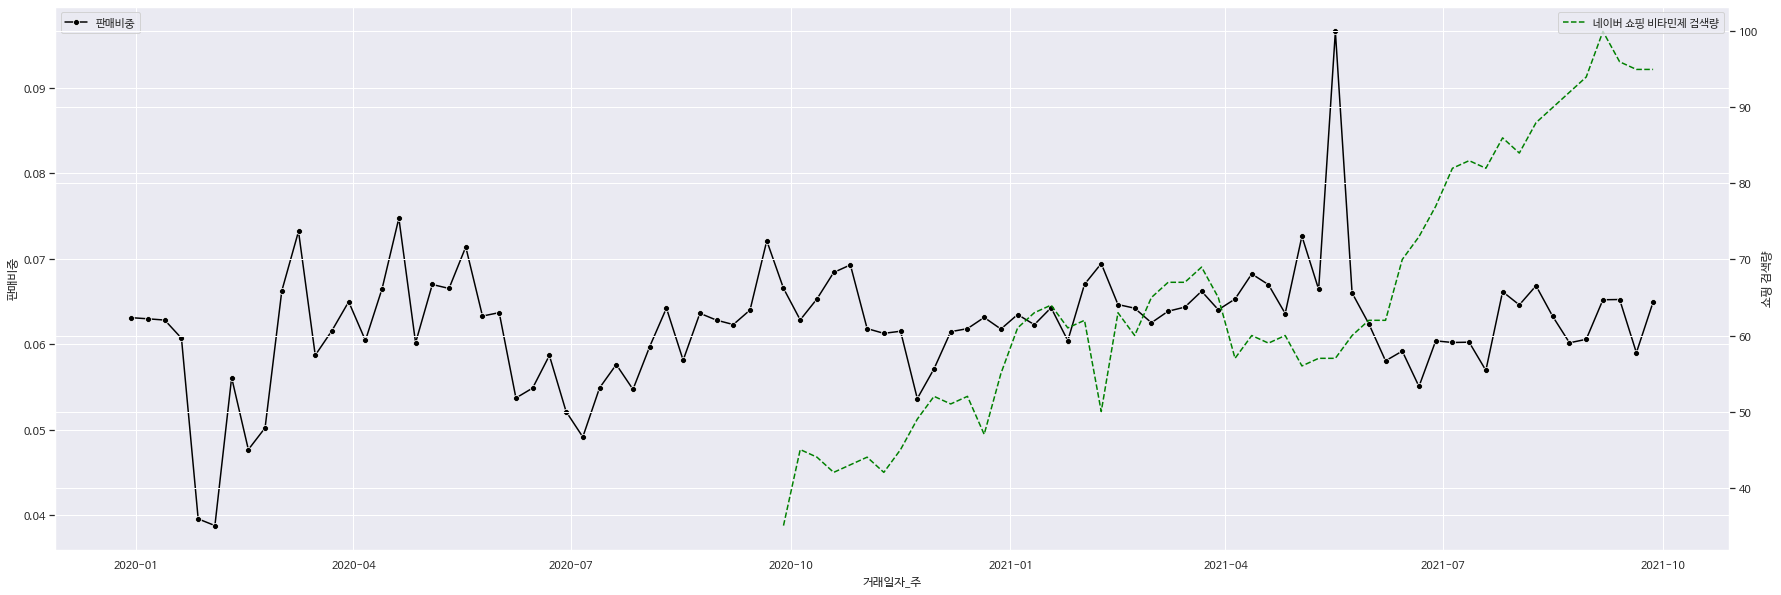

In [ ]:
#  코로나 확진 추이 + 쇼핑 트렌드 추가
condition = table1[table1['온누리상품소분류카테고리명'] == '종합비타민/비타민B/비타민C']

sns.set(font='NanumBarunGothic', 
        rc={"axes.unicode_minus":False},
        style='darkgrid')
plt.figure(figsize = (30,10))
sns.lineplot(data=condition,  x='거래일자_주', y='판매비중', marker= "o", color = 'black')
plt.legend(labels=['판매비중'],loc = 2)



ax2 = plt.twinx()
sns.lineplot(data = shopping, x = '거래일자_주', y = '쇼핑 검색량', color = 'green', linestyle='--', ax=ax2)

plt.legend(labels=['네이버 쇼핑 비타민제 검색량'],loc = 1)

- 클러스트링

In [ ]:
cluster = table1.pivot(index='거래일자_주', columns = '온누리상품소분류카테고리명', values = '판매비중').fillna(0)
cluster_train = cluster.iloc[:, 1:]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(cluster)

cluster_scaled_v = scaler.transform(cluster)

In [ ]:
cluster_scaled = pd.DataFrame(data = cluster_scaled_v, columns = cluster.columns)

In [ ]:
cluster_scaled.T.head()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3)
agg.fit( cluster_scaled.T )

AgglomerativeClustering(n_clusters=3)

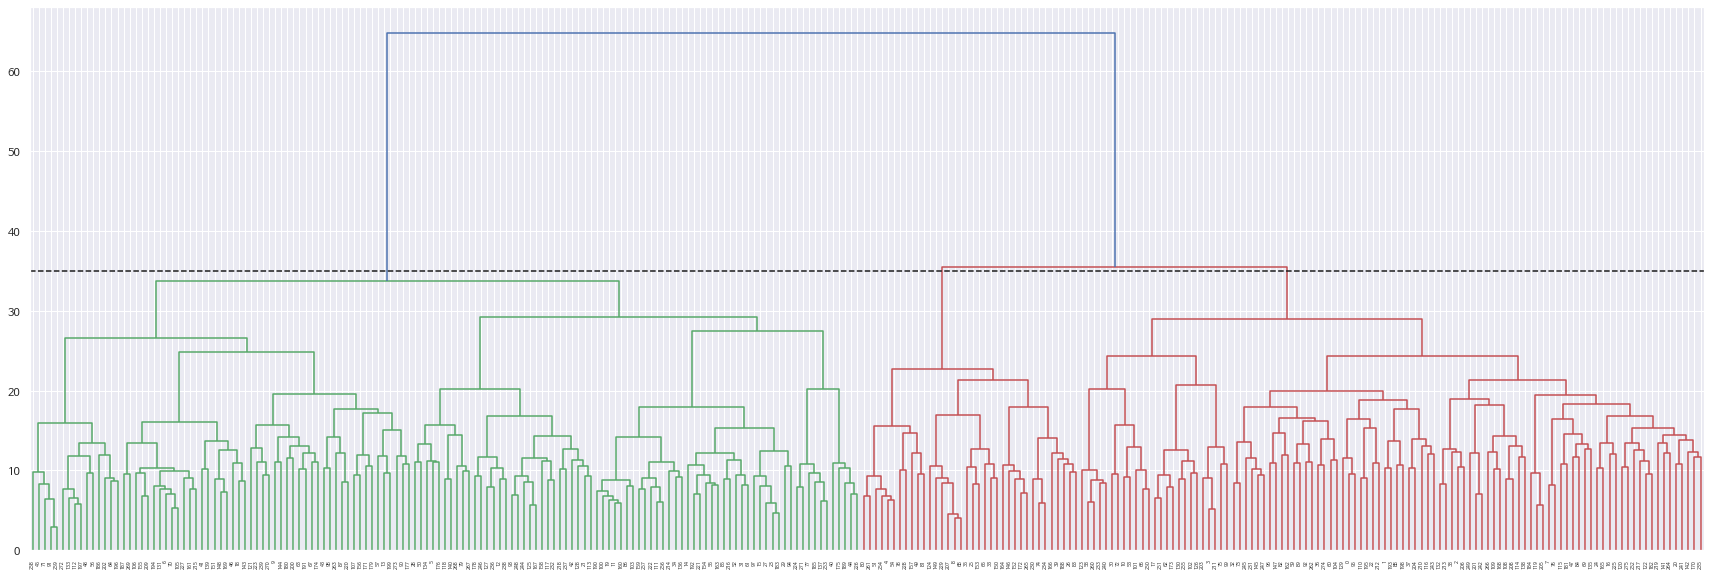

In [ ]:
# 덴드로그램으로 시각화
from scipy.cluster.hierarchy import dendrogram, link

# SciPy의 ward 함수는 병합 군집을 수행할 때 생성된
# 거리 정보가 담긴 배열을 리턴
linkage_array = ward( cluster_scaled.T )
plt.figure(figsize = (30,10))
# 클러스터 간의 거리 정보가 담긴 linkage_array를 사용해 덴드로그램으로 시각화
dendrogram( linkage_array )

# 두 개와 세 개의 클러스터를 구분하는 커트라인을 표시


ax = plt.gca()
bounds = ax.get_xbound()
plt.plot(bounds, [35, 35], '--', c='k')       # 3개 클러스터
plt.show()

In [ ]:
table1 = data.groupby(['거래일자_주', '온누리상품소분류카테고리명'])['판매비중'].sum().reset_index()

In [ ]:
new_cluster = cluster_scaled.T.reset_index()
new_cluster['label_agg']= agg.labels_
label = new_cluster[['온누리상품소분류카테고리명','label_agg']]

table1 = table1.merge( new_cluster[['온누리상품소분류카테고리명','label_agg']], on = '온누리상품소분류카테고리명')

Text(0.5, 1.0, 'group1')

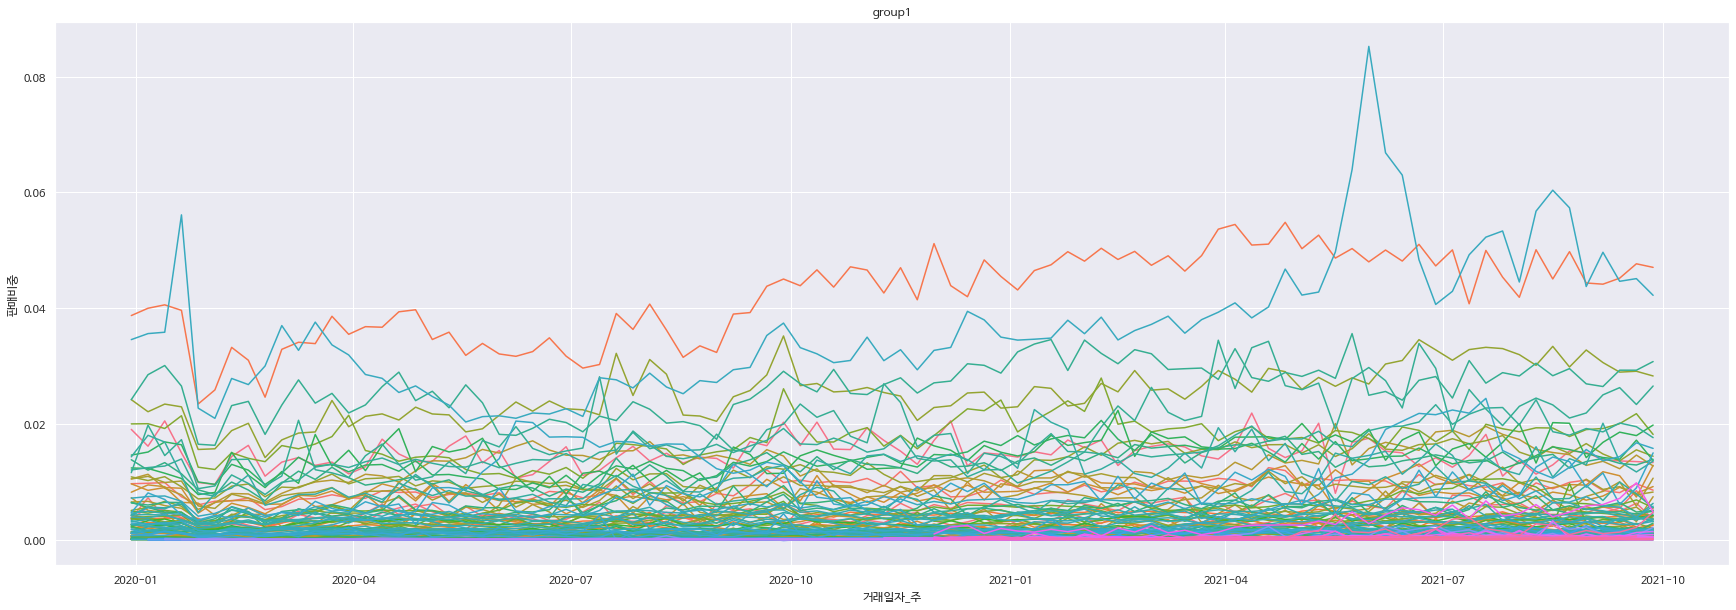

In [ ]:
condition = table1[table1['label_agg'] == 0]
plt.figure(figsize = (30,10))
sns.lineplot(data=condition,  x='거래일자_주', y='판매비중', hue='온누리상품소분류카테고리명', legend = False)

plt.title("group1")

In [ ]:
condition.groupby('온누리상품소분류카테고리명')['판매비중'].sum().sort_values(ascending = False)

Text(0.5, 1.0, 'group1')

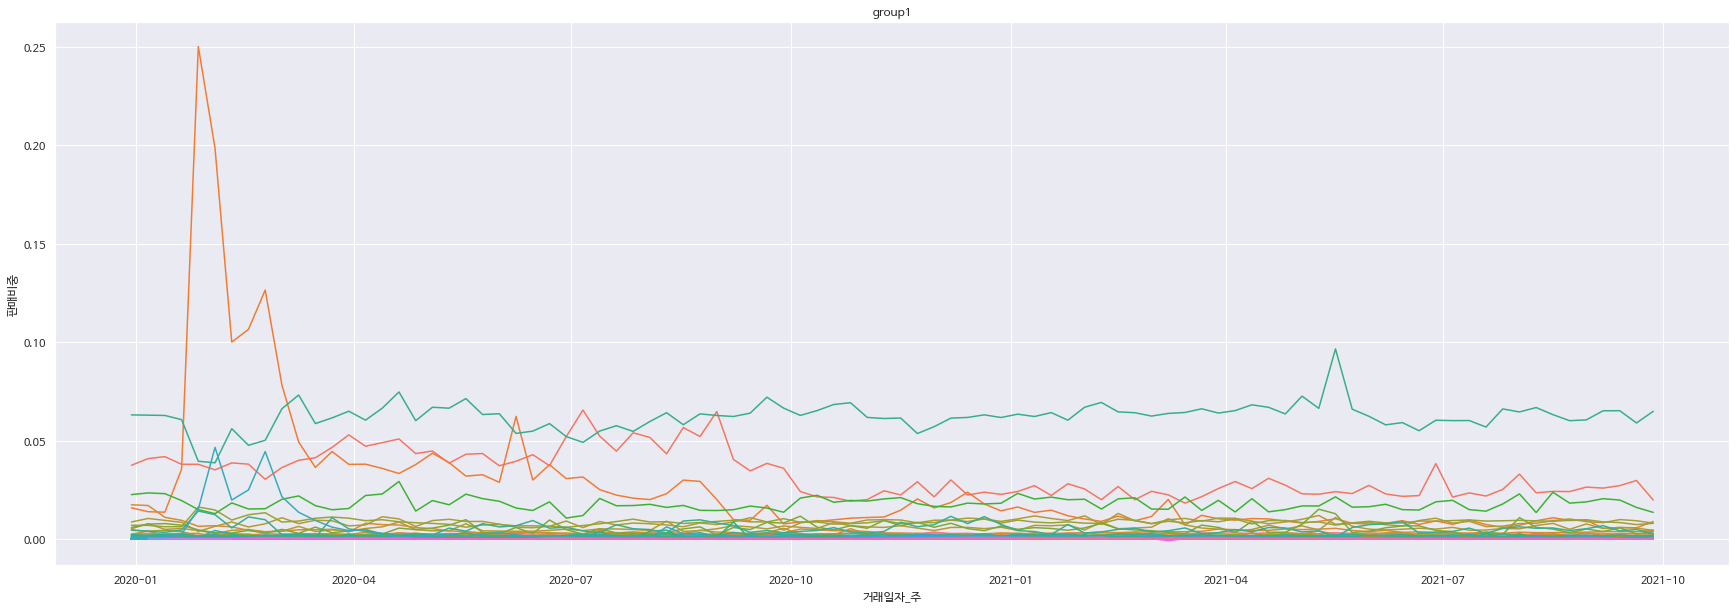

In [ ]:
condition = table1[table1['label_agg'] == 1]
condition = condition[condition['온누리상품소분류카테고리명'] != '미분류상품']
plt.figure(figsize = (30,10))
sns.lineplot(data=condition,  x='거래일자_주', y='판매비중', hue='온누리상품소분류카테고리명', legend = False)

plt.title("group1")

In [ ]:
condition.groupby('온누리상품소분류카테고리명')['판매비중'].sum().sort_values(ascending = False)

온누리상품소분류카테고리명
종합비타민/비타민B/비타민C          5.728905e+00
기타                       3.032716e+00
마스크                      2.418777e+00
유산균                      1.657324e+00
소독용품                     8.115916e-01
뼈건강/비타민D                 8.001165e-01
빈혈·어지러움                  5.165636e-01
쌍화/인삼/산삼/홍삼/녹용           4.982946e-01
체온계                      4.968586e-01
멀미/구충                    3.967658e-01
핸드워시/손소독제                3.104942e-01
가글                       2.371459e-01
베타카로틴/비타민E/셀레늄           2.279408e-01
숙취해소                     1.863583e-01
칫솔                       1.695938e-01
방광,전립선건강/정력증진            1.668473e-01
비타민A (눈관련)               1.457030e-01
코엔자임큐텐                   1.352078e-01
신경·순환기계                  1.128009e-01
당뇨·혈당건강                  1.049359e-01
비듬·지루성피부                 9.996141e-02
콘텍트렌즈용품                  9.497083e-02
자양강장                     5.547247e-02
피부·알레르기                  5.355917e-02
애견용품                     4.645420e-02
생리대                      4.577074e-0

Text(0.5, 1.0, 'group1')

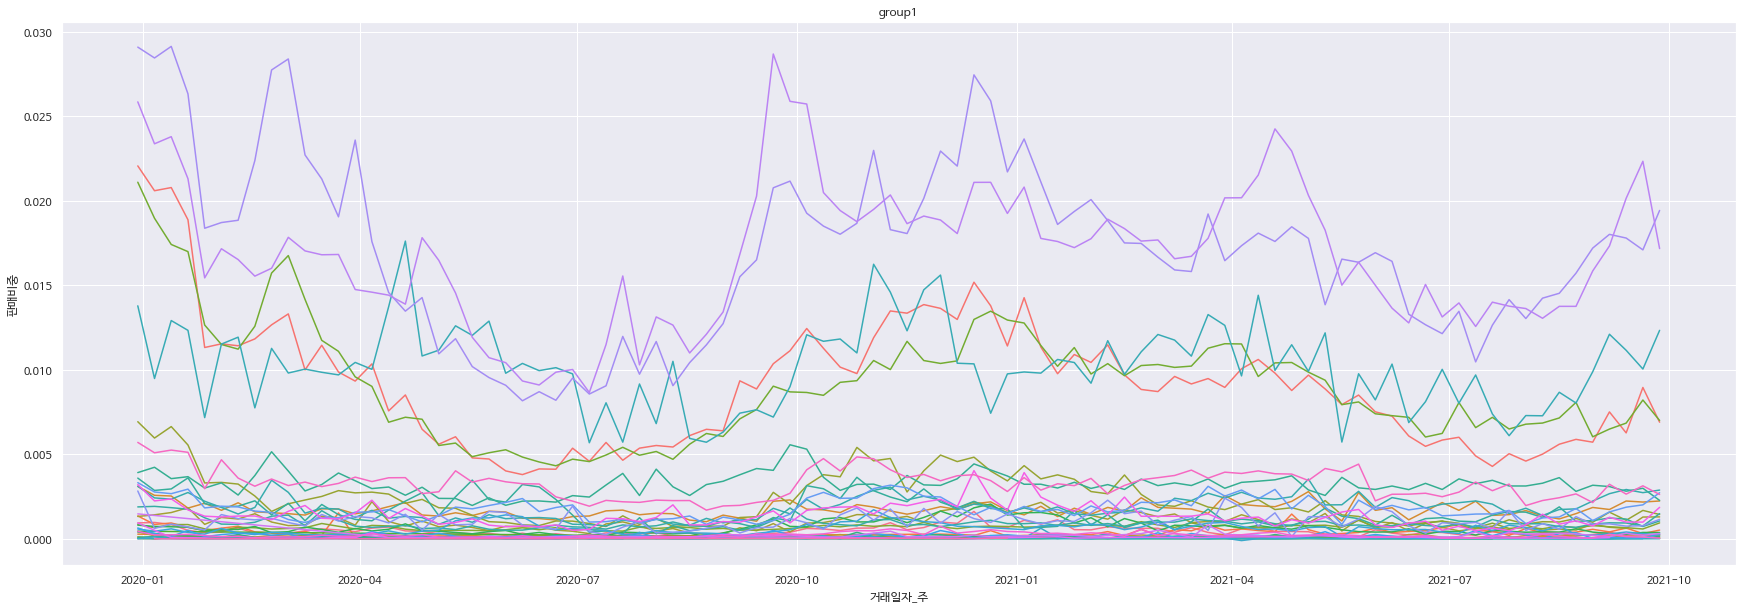

In [ ]:
condition = table1[table1['label_agg'] == 2]
condition = condition[condition['온누리상품소분류카테고리명'] != '미분류상품']
plt.figure(figsize = (30,10))
sns.lineplot(data=condition,  x='거래일자_주', y='판매비중', hue='온누리상품소분류카테고리명', legend = False)

plt.title("group1")

In [ ]:
condition.groupby('온누리상품소분류카테고리명')['판매비중'].sum().sort_values(ascending = False)

온누리상품소분류카테고리명
종합감기              1.568952
코감기/알레르기          1.546594
어린이비타민            0.939870
감기/쌍화탕            0.839614
목감기               0.838026
헬시푸드              0.300920
소염                0.299234
립케어               0.212055
어린이감기             0.172898
유아식품              0.167570
기타 의료기기·용품        0.160122
약국전용              0.145195
핫팩·찜질팩·기기         0.130075
임산부영양             0.098255
로션/크림/오일          0.094312
어린이 해열·진통         0.085833
면봉/화장솜/기름종이       0.064658
발·다리 보습           0.062103
완구 및 캐릭터          0.055833
각피증               0.042817
국소진통완화제           0.028529
핸드케어              0.020046
요실금·성인용기저귀        0.017534
네일/발관리용품          0.014853
발각질제거             0.010795
귀관리용품             0.010519
코엔자임Q10           0.009983
클렌저               0.004472
여성전문              0.004455
발·다리 세정           0.004166
동상                0.001804
나잘스프레이            0.001406
미용관련제품(기미/주근깨)    0.000723
캔디류               0.000167
어린이음료             0.000108
바디/핸드케어           0.000018
Name: 판매비중, dt

In [ ]:
from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=123).fit(cluster_train)

In [ ]:
cluster['label'] = kmeans.labels_
label = cluster[['온누리상품소분류카테고리명','label']]

In [ ]:
table1 = table1.merge(cluster[['온누리상품소분류카테고리명','label']], on = '온누리상품소분류카테고리명')

Text(0.5, 1.0, 'group1')

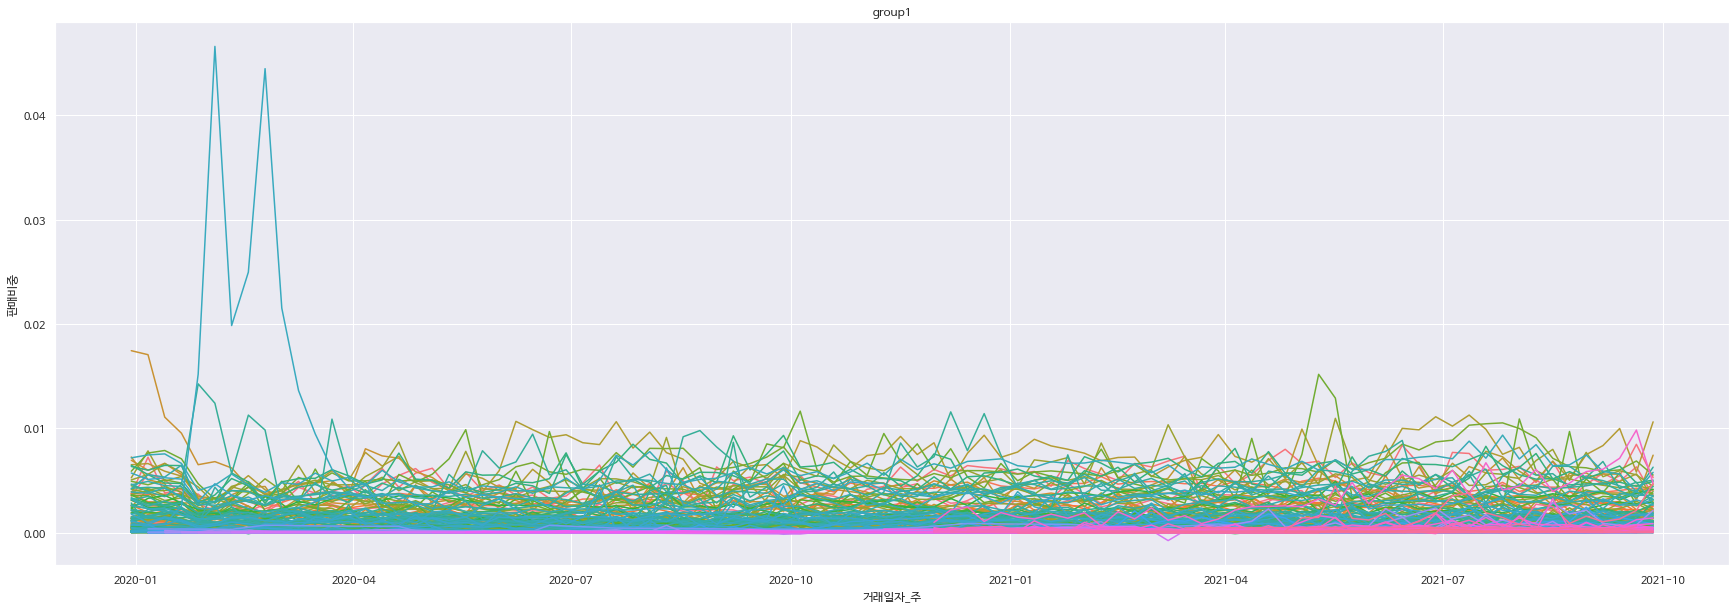

In [ ]:
condition = table1[table1['label'] == 0]
plt.figure(figsize = (30,10))
sns.lineplot(data=condition,  x='거래일자_주', y='판매비중', hue='온누리상품소분류카테고리명', legend = False)

plt.title("group1")

In [ ]:
table1[table1['label'] == 0][table1[table1['label'] == 0]['판매비중'] > 0.04]

거래일자_주 온누리상품소분류카테고리명      판매비중  label
14266 2020-02-03     핸드워시/손소독제  0.046600      0
14269 2020-02-24     핸드워시/손소독제  0.044467      0

Text(0.5, 1.0, 'group3')

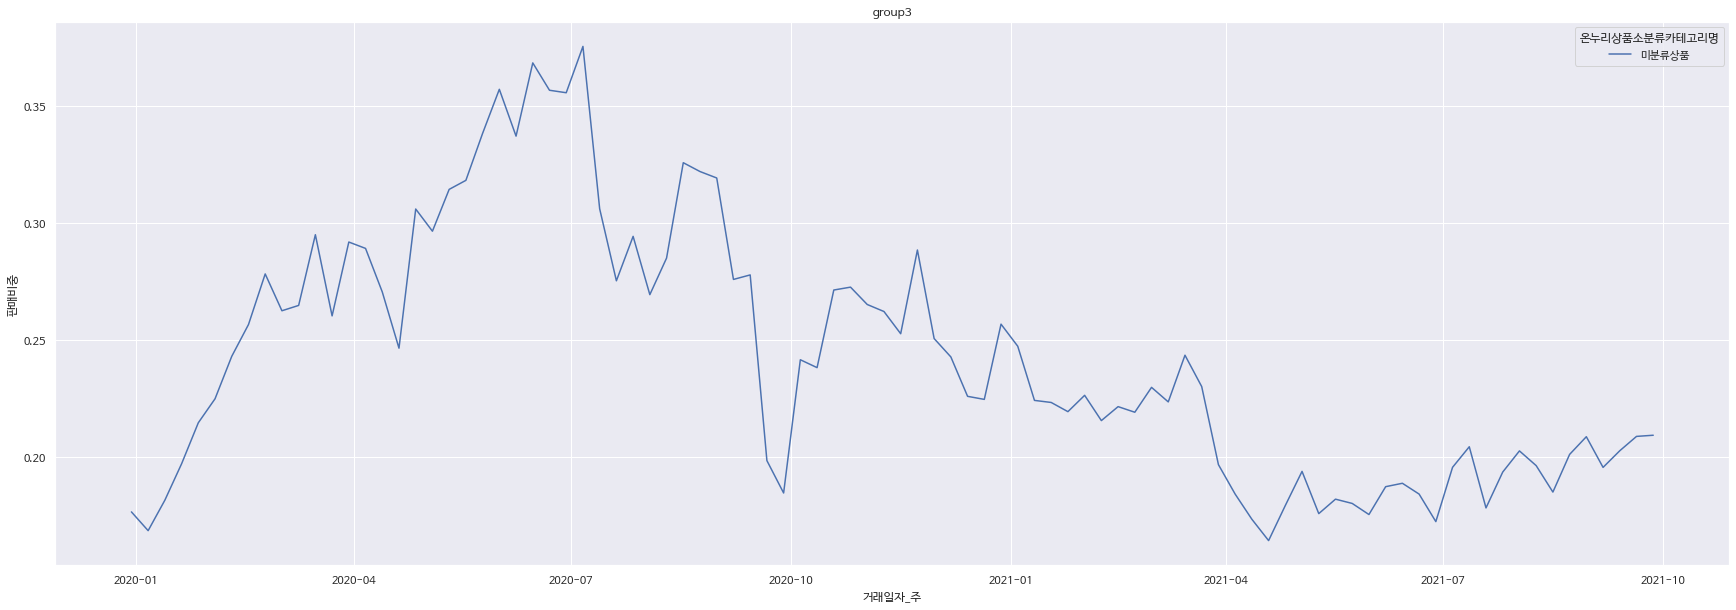

In [ ]:
condition = table1[table1['label'] == 1]
plt.figure(figsize = (30,10))
sns.lineplot(data=condition,  x='거래일자_주', y='판매비중', hue='온누리상품소분류카테고리명')

plt.title("group3")

Text(0.5, 1.0, 'group4')

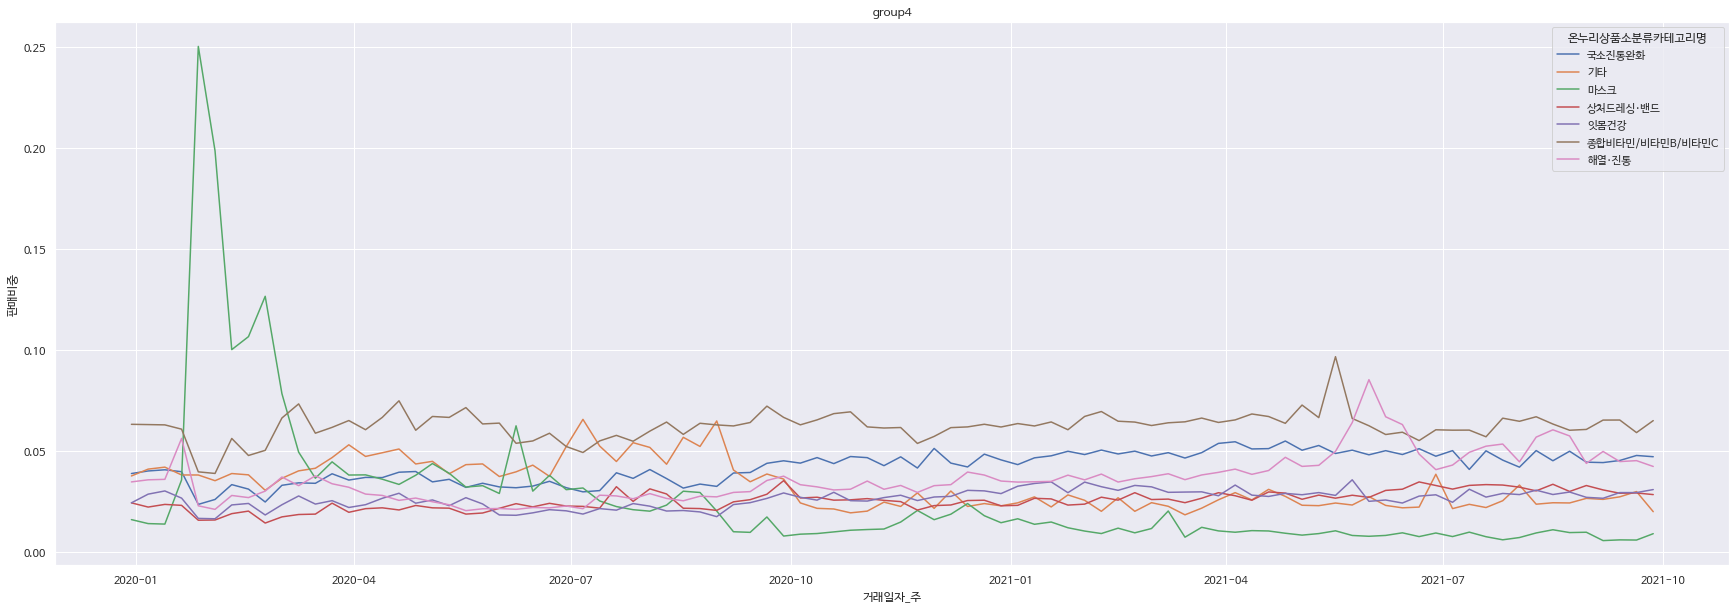

In [ ]:
condition = table1[table1['label'] == 2]
plt.figure(figsize = (30,10))
sns.lineplot(data=condition,  x='거래일자_주', y='판매비중', hue='온누리상품소분류카테고리명')

plt.title("group4")

Text(0.5, 1.0, 'group2')

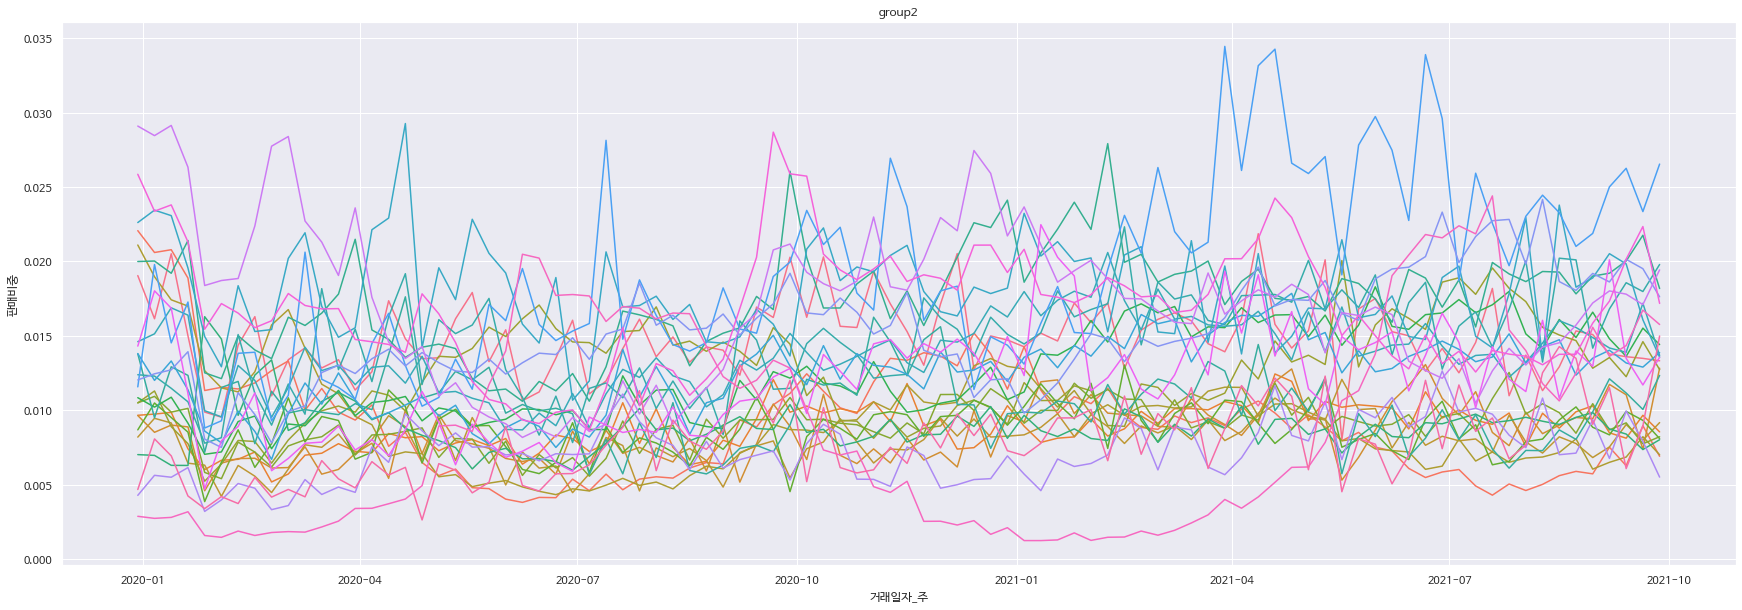

In [ ]:
condition = table1[table1['label'] == 3]
plt.figure(figsize = (30,10))
sns.lineplot(data=condition,  x='거래일자_주', y='판매비중', hue='온누리상품소분류카테고리명',legend = False)

plt.title("group2")

In [ ]:
temp = data.groupby('온누리상품소분류카테고리명')['상품판매금액'].sum()
temp.sort_values(ascending= False).head()

온누리상품소분류카테고리명
미분류상품              17863812809
종합비타민/비타민B/비타민C     5213002291
국소진통완화              2777075929
기타                  2373595186
해열·진통               2286173251
Name: 상품판매금액, dtype: int64

- 광주지역 분석

In [ ]:
data[data['온누리상품소분류카테고리명'] == '종합비타민/비타민B/비타민C']


table3 = data[data['온누리상품소분류카테고리명'] == '종합비타민/비타민B/비타민C'].groupby(''구매상품명')['상품판매금액'].sum()
table3.sort_values().tail(10)

구매상품명
임팩타민케어정            100448100
트리플비타민C1000        103381466
임팩타민프리미엄정          110877000
대웅임팩타민프리미엄정        117390000
코텐비타연질캡슐           121352000
아로나민씨플러스정          139648494
고려은단비타민씨 1000mg    175495030
비타비백정              182663800
비맥스메타정             385095499
아로나민골드정            394724200
Name: 상품판매금액, dtype: int64

In [ ]:
table4 =  data[data['구매상품명'] == '비맥스메타정'].groupby('거래일자_주')['판매비중'].sum()

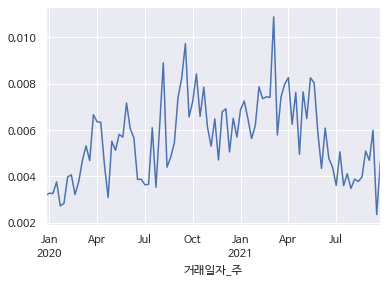

In [ ]:
table4.plot()

In [ ]:
table = data.groupby(['온누리상품소분류카테고리명'])['상품판매금액'].sum()
table.sort_values(ascending=False).head(40)

온누리상품소분류카테고리명
미분류상품                  17863812809
종합비타민/비타민B/비타민C         5213002291
국소진통완화                  2777075929
기타                      2373595186
해열·진통                   2286173251
마스크                     2183067789
잇몸건강                    1744578178
상처드레싱·밴드                1672270081
유산균                     1250573278
자양강장 고농축앰플제             1249497875
소화                      1141565970
종합감기                    1131701227
코감기/알레르기                1123424003
간건강                     1014037009
오메가3                     973486620
위장                       904122834
무좀·진균                    845068693
상처/흉터                    809586017
인공눈물                     809269642
청심원/천왕보심단                760592013
어린이비타민                   727059540
감기/쌍화탕                   610425407
목감기                      601728242
해충·방충·모기기피제              600967943
소독용품                     600332761
변비                       591478506
관절보호대                    590710676
뼈건강/비타민D                 589944092
루테인   

In [ ]:
# 2.그룹바이

temp = data[data['온누리상품소분류카테고리명'] == '마스크']
table = temp.groupby(['거래일자_주', '온누리상품소분류카테고리명'])['상품판매금액'].sum()
table = table.reset_index()
# table['거래일자_주'] = table['거래일자_주'].astype(str)

In [ ]:
temp2 = data[data['온누리상품소분류카테고리명'] == '종합비타민/비타민B/비타민C']
table2 = temp2.groupby(['거래일자_주', '온누리상품소분류카테고리명'])['상품판매금액'].sum()
table2 = table2.reset_index()

In [ ]:
# table = data.groupby(['온누리상품소분류카테고리명'])['상품판매금액'].sum()
# table.sort_values(ascending=False).head(40)

In [ ]:
table3 = new_c.groupby('거래일자_주')['확진자수'].sum()
table3 = table3.reset_index()

In [ ]:
table2.head()

Empty DataFrame
Columns: [거래일자_주, 온누리상품소분류카테고리명, 상품판매금액]
Index: []

In [ ]:
table2

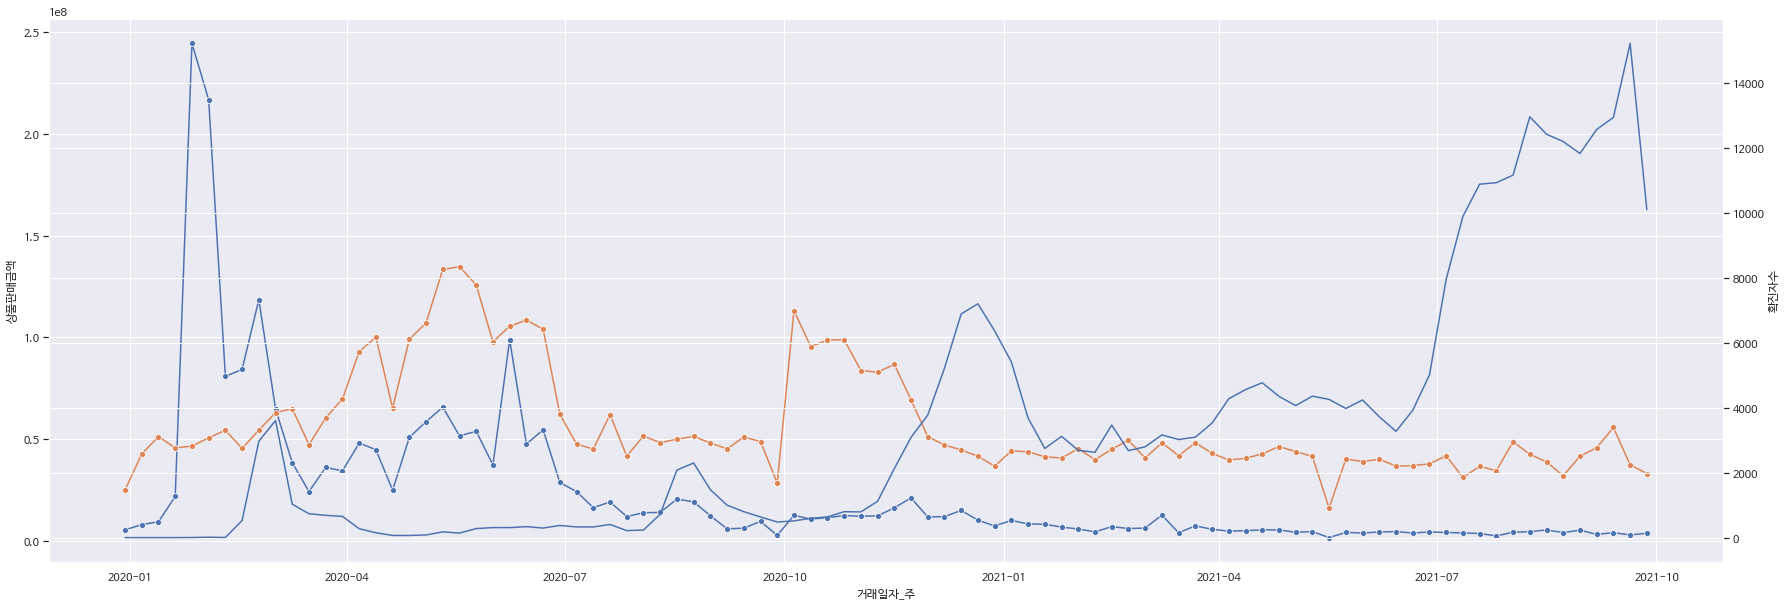

In [ ]:
plt.figure(figsize = (30,10))
sns.lineplot(data=table,  x='거래일자_주', y='상품판매금액', marker= "o")
sns.lineplot(data=table2, x='거래일자_주', y='상품판매금액', marker= "o")

ax2 = plt.twinx()
sns.lineplot(data = table3, x = '거래일자_주', y = '확진자수', ax=ax2)

In [ ]:
temp10 = df[df['label'] == 2]
group10 = temp10.groupby(['거래일자_주', '온누리상품소분류카테고리명'])['상품판매금액'].sum().reset_index()

In [ ]:
df[df['온누리상품소분류카테고리명'] == '종합비타민/비타민B/비타민C']

거래일자_주    온누리상품소분류카테고리명    상품판매금액  label
19136 2019-12-30  종합비타민/비타민B/비타민C  0.426158      2
19137 2020-01-06  종합비타민/비타민B/비타민C  0.448167      2
19138 2020-01-13  종합비타민/비타민B/비타민C  0.416555      2
19139 2020-01-20  종합비타민/비타민B/비타민C  0.378981      2
19140 2020-01-27  종합비타민/비타민B/비타민C  0.190123      2
19141 2020-02-03  종합비타민/비타민B/비타민C  0.205888      2
19142 2020-02-10  종합비타민/비타민B/비타민C  0.276867      2
19143 2020-02-17  종합비타민/비타민B/비타민C  0.223933      2
19144 2020-02-24  종합비타민/비타민B/비타민C  0.208469      2
19145 2020-03-02  종합비타민/비타민B/비타민C  0.290098      2
19146 2020-03-09  종합비타민/비타민B/비타민C  0.315390      2
19147 2020-03-16  종합비타민/비타민B/비타민C  0.241415      2
19148 2020-03-23  종합비타민/비타민B/비타민C  0.286672      2
19149 2020-03-30  종합비타민/비타민B/비타민C  0.264502      2
19150 2020-04-06  종합비타민/비타민B/비타민C  0.255051      2
19151 2020-04-13  종합비타민/비타민B/비타민C  0.297111      2
19152 2020-04-20  종합비타민/비타민B/비타민C  0.355177      2
19153 2020-04-27  종합비타민/비타민B/비타민C  0.241349      2
19154 2020-05-04  종합비타민/비타민B/비타민C  0.269495      2
19155 2020-05-11  종합비타민/비타민B/비타민C  0.251064      2
19156 2020-05-18  종합비타민/비타민B/비타민C  0.262903      2
19157 2020-05-25  종합비타민/비타민B/비타민C  0.225847      2
19158 2020-06-01  종합비타민/비타민B/비타민C  0.212179      2
19159 2020-06-08  종합비타민/비타민B/비타민C  0.197243      2
19160 2020-06-15  종합비타민/비타민B/비타민C  0.185713      2
19161 2020-06-22  종합비타민/비타민B/비타민C  0.202020      2
19162 2020-06-29  종합비타민/비타민B/비타민C  0.187540      2
19163 2020-07-06  종합비타민/비타민B/비타민C  0.165647      2
19164 2020-07-13  종합비타민/비타민B/비타민C  0.227818      2
19165 2020-07-20  종합비타민/비타민B/비타민C  0.265006      2
19166 2020-07-27  종합비타민/비타민B/비타민C  0.247893      2
19167 2020-08-03  종합비타민/비타민B/비타민C  0.279585      2
19168 2020-08-10  종합비타민/비타민B/비타민C  0.281555      2
19169 2020-08-17  종합비타민/비타민B/비타민C  0.224658      2
19170 2020-08-24  종합비타민/비타민B/비타민C  0.244489      2
19171 2020-08-31  종합비타민/비타민B/비타민C  0.247650      2
19172 2020-09-07  종합비타민/비타민B/비타민C  0.279238      2
19173 2020-09-14  종합비타민/비타민B/비타민C  0.287268      2
19174 2020-09-21  종합비타민/비타민B/비타민C  0.448134      2
19175 2020-09-28  종합비타민/비타민B/비타민C  0.462886      2
19176 2020-10-05  종합비타민/비타민B/비타민C  0.326808      2
19177 2020-10-12  종합비타민/비타민B/비타민C  0.341722      2
19178 2020-10-19  종합비타민/비타민B/비타민C  0.315049      2
19179 2020-10-26  종합비타민/비타민B/비타민C  0.313044      2
19180 2020-11-02  종합비타민/비타민B/비타민C  0.288522      2
19181 2020-11-09  종합비타민/비타민B/비타민C  0.291821      2
19182 2020-11-16  종합비타민/비타민B/비타민C  0.312469      2
19183 2020-11-23  종합비타민/비타민B/비타민C  0.233127      2
19184 2020-11-30  종합비타민/비타민B/비타민C  0.278859      2
19185 2020-12-07  종합비타민/비타민B/비타민C  0.304164      2
19186 2020-12-14  종합비타민/비타민B/비타민C  0.318044      2
19187 2020-12-21  종합비타민/비타민B/비타민C  0.327749      2
19188 2020-12-28  종합비타민/비타민B/비타민C  0.284408      2
19189 2021-01-04  종합비타민/비타민B/비타민C  0.293897      2
19190 2021-01-11  종합비타민/비타민B/비타민C  0.322400      2
19191 2021-01-18  종합비타민/비타민B/비타민C  0.338768      2
19192 2021-01-25  종합비타민/비타민B/비타민C  0.330750      2
19193 2021-02-01  종합비타민/비타민B/비타민C  0.358085      2
19194 2021-02-08  종합비타민/비타민B/비타민C  0.386142      2
19195 2021-02-15  종합비타민/비타민B/비타민C  0.344781      2
19196 2021-02-22  종합비타민/비타민B/비타민C  0.354402      2
19197 2021-03-01  종합비타민/비타민B/비타민C  0.330012      2
19198 2021-03-08  종합비타민/비타민B/비타민C  0.348781      2
19199 2021-03-15  종합비타민/비타민B/비타민C  0.318886      2
19200 2021-03-22  종합비타민/비타민B/비타민C  0.349674      2
19201 2021-03-29  종합비타민/비타민B/비타민C  0.403174      2
19202 2021-04-05  종합비타민/비타민B/비타민C  0.448102      2
19203 2021-04-12  종합비타민/비타민B/비타민C  0.501745      2
19204 2021-04-19  종합비타민/비타민B/비타민C  0.506823      2
19205 2021-04-26  종합비타민/비타민B/비타민C  0.447268      2
19206 2021-05-03  종합비타민/비타민B/비타민C  0.455236      2
19207 2021-05-10  종합비타민/비타민B/비타민C  0.478248      2
19208 2021-05-17  종합비타민/비타민B/비타민C  0.619119      2
19209 2021-05-24  종합비타민/비타민B/비타민C  0.447810      2
19210 2021-05-31  종합비타민/비타민B/비타민C  0.454957      2
19211 2021-06-07  종합비타민/비타민B/비타민C  0.407291      2
19212 2021-06-14  종합비타민/비타민B/비타민C  0.409338      2
19213 2021-06-21  종합비타민/비타민B/비타민

In [ ]:
df[df['label'] == 2]['온누리상품소분류카테고리명'].value_counts()

국소진통완화             92
종합비타민/비타민B/비타민C    92
해열·진통              92
Name: 온누리상품소분류카테고리명, dtype: int64

In [ ]:
data[data['label'] == 2]['온누리상품소분류카테고리명']

206785      해열·진통
206786      해열·진통
206787      해열·진통
206788      해열·진통
206789      해열·진통
            ...  
6032905    국소진통완화
6032906    국소진통완화
6032907    국소진통완화
6032908    국소진통완화
6032909    국소진통완화
Name: 온누리상품소분류카테고리명, Length: 1459773, dtype: object

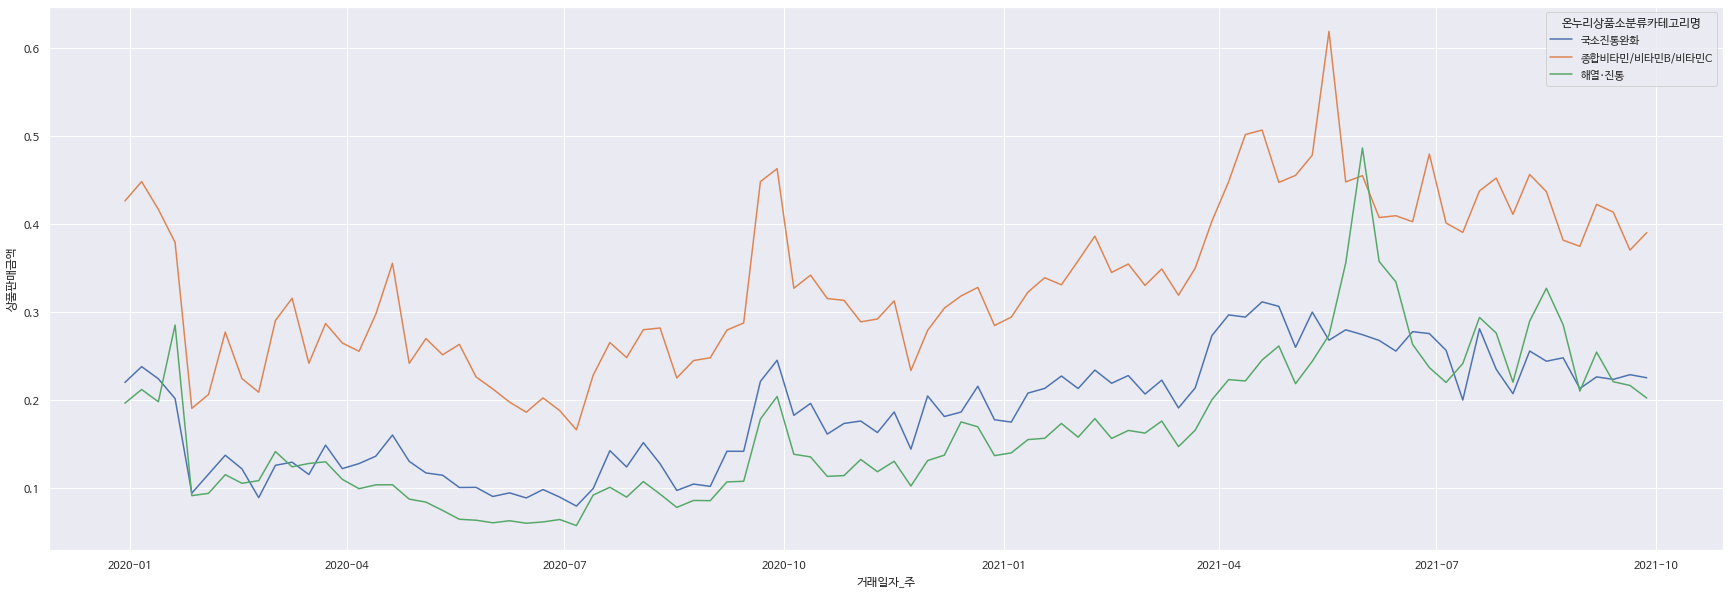

In [ ]:
plt.figure(figsize = (30,10))
sns.lineplot(data = group10, x = '거래일자_주', y = '상품판매금액', ci = None, hue = '온누리상품소분류카테고리명')

In [ ]:
temp11 = data[data['label'] == 1]
group11 = temp11.groupby(['거래일자_주', '온누리상품소분류카테고리명'])['상품판매금액'].sum().reset_index()

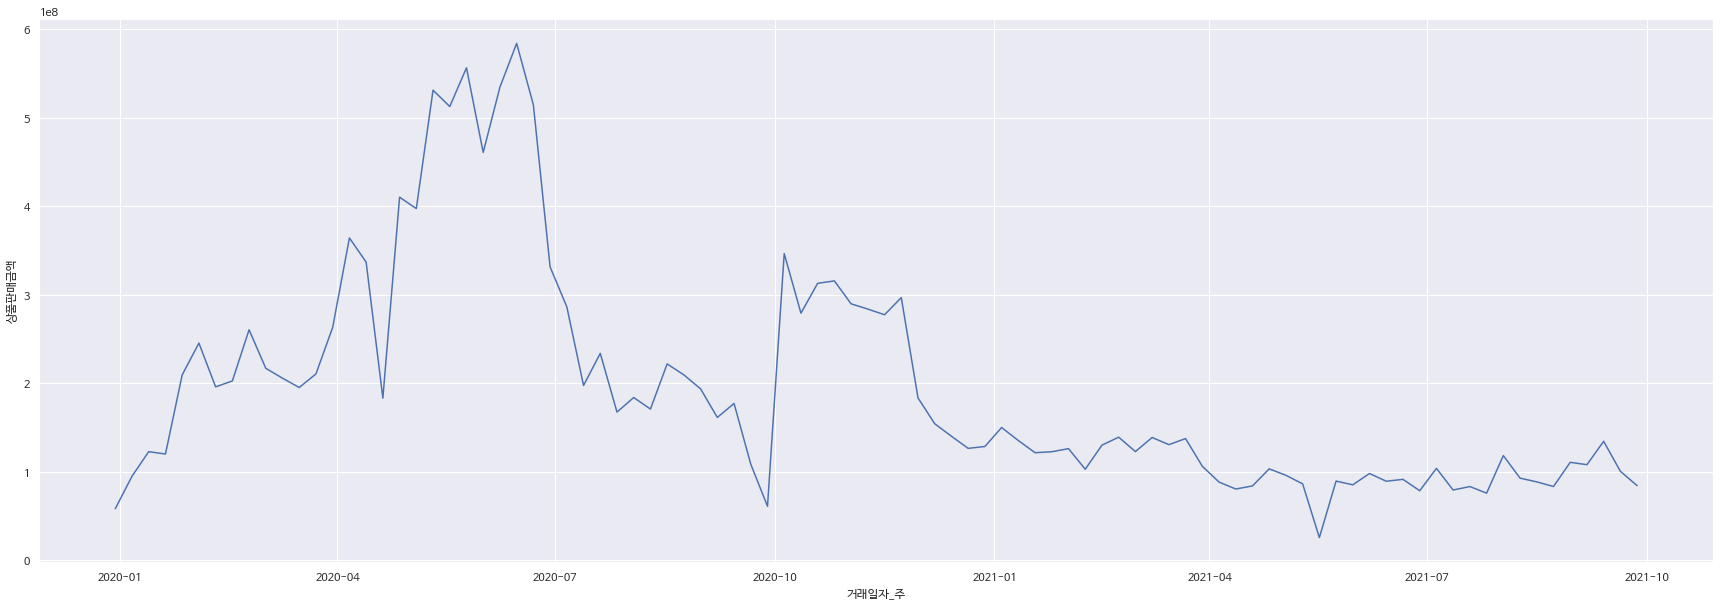

In [ ]:
plt.figure(figsize = (30,10))
sns.lineplot(data = group11, x = '거래일자_주', y = '상품판매금액', ci = None, hue = '온누리상품소분류카테고리명', legend=None)

In [ ]:
data[data['label'] == 2]['온누리상품소분류카테고리명'].value_counts().head(20)

국소진통완화             468889
종합비타민/비타민B/비타민C    383649
마스크                250187
기타                 226174
Name: 온누리상품소분류카테고리명, dtype: int64

In [ ]:
temp12 = data[data['label'] == 3]
group12 = temp12.groupby(['거래일자_주', '온누리상품소분류카테고리명'])['상품판매금액'].sum().reset_index()

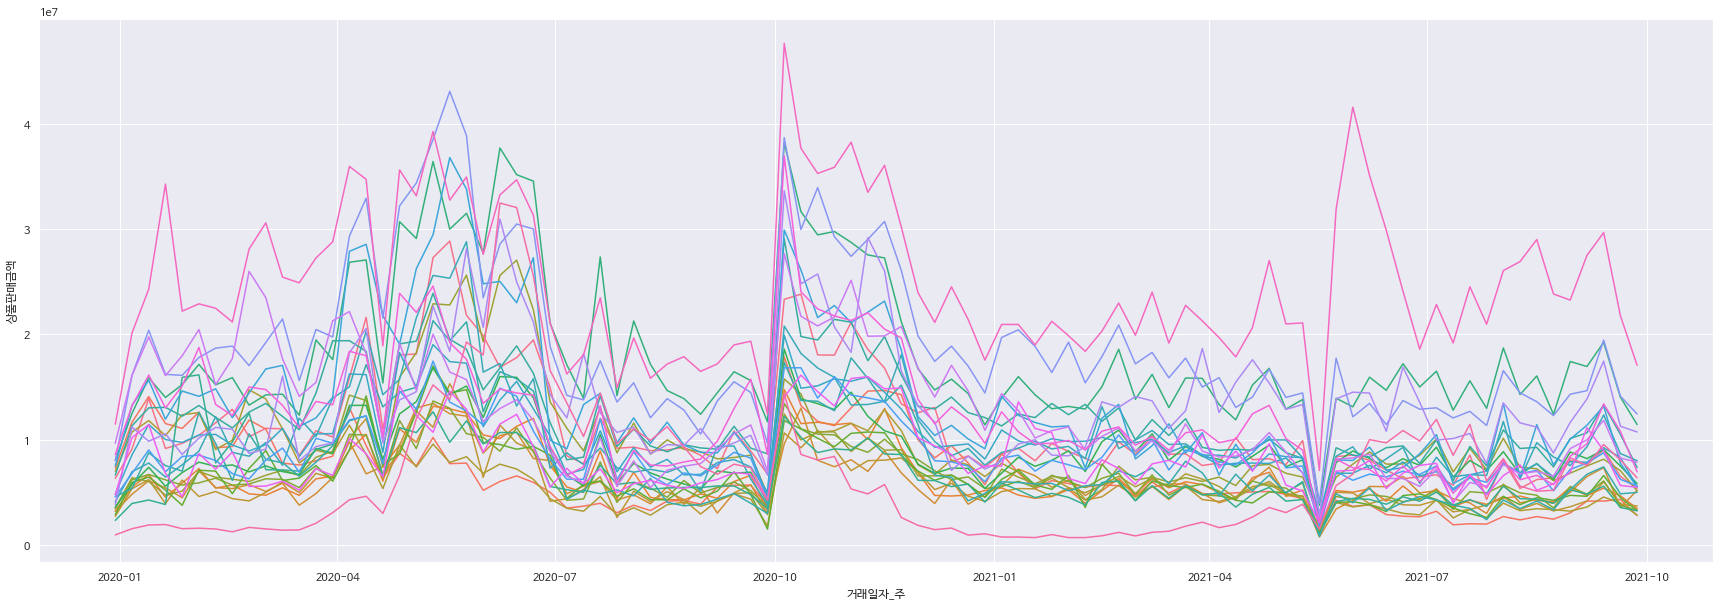

In [ ]:
plt.figure(figsize = (30,10))
sns.lineplot(data = group12, x = '거래일자_주', y = '상품판매금액', ci = None, hue = '온누리상품소분류카테고리명', legend=None)

In [ ]:
data[data['label'] == 3]['온누리상품소분류카테고리명'].value_counts()

해열·진통          607235
상처드레싱·밴드       439225
소화             259744
종합감기           220239
코감기/알레르기       213145
소독용품           198030
위장             190070
목감기            140998
감기/쌍화탕         138414
상처/흉터          120477
인공눈물           113257
잇몸건강           104797
해충·방충·모기기피제     98863
변비              84978
어린이비타민          76916
무좀·진균           74867
자양강장 고농축앰플제     65824
간건강             63206
청심원/천왕보심단       57205
관절보호대           43688
유산균             31624
마그네슘            19956
오메가3            18919
뼈건강/비타민D        17717
루테인             12994
Name: 온누리상품소분류카테고리명, dtype: int64

In [ ]:
group = data.groupby(['거래일자_월', '온누리상품대분류카테고리명'])['상품판매금액'].sum()
group = group.reset_index()

In [ ]:
group['거래일자_월'] = group['거래일자_월'].astype('str')

In [ ]:
fig.show(renderer="colab")

In [ ]:
plt.figure(figsize = (30,10))
sns.barplot(data=group, x= '거래일자_월', y= '상품판매금액', ci = None, hue = '온누리상품대분류카테고리명', dodge = True)

In [ ]:
join_item = group.groupby('거래일자_월')['상품판매금액'].sum()

In [ ]:
join_item = join_item.to_frame()
join_item = join_item.reset_index()

join_item.columns = ['거래일자_월', '총금액']

In [ ]:
new_group = group.merge(join_item, on='거래일자_월', how='inner')

In [ ]:
new_group['비율'] = new_group['상품판매금액'] / new_group['총금액']

In [ ]:
new_group['거래일자_']= new_group['거래일자_월'].astype(str)

In [ ]:
data

거래일자    우편번호 시도명 시군구명  읍면동명 온누리상품대분류카테고리명  온누리상품중분류카테고리명    온누리상품소분류카테고리명  상품판매수량  상품판매금액          구매상품명   거래일자_월
0       2020-01-02  406110  인천  연수구   연수동         일반의약품             감기              목감기       2    6000     케어콜드코프연질캡슐  2020-01
1       2020-01-02  406110  인천  연수구   연수동         일반의약품            한방약            통증·염증       2    6000           월드로신  2020-01
2       2020-01-02  406110  인천  연수구   연수동         일반의약품   해열/진통/소염/근이완            해열·진통       2    6000           하이펜정  2020-01
3       2020-01-02  406110  인천  연수구   연수동            기타            nan            미분류상품       1   15000            안아파  2020-01
4       2020-01-02  406110  인천  연수구   연수동            헬스        응급·구급처치         상처드레싱·밴드       1    1000  디스밴드종이반창고(살색)  2020-01
...            ...     ...  ..  ...   ...           ...            ...              ...     ...     ...            ...      ...
8412833 2021-09-30  139802  서울  노원구  공릉2동            헬스        피로/건강증진  종합비타민/비타민B/비타민C       2   10000         동아박카스D  2021-09
8412834 2021-09-30  139802  서울  노원구  공릉2동            헬스        피로/건강증진  종합비타민/비타민B/비타민C       2   10000         동아박카스D  2021-09
8412835 2021-09-30  139802  서울  노원구  공릉2동            헬스        피로/건강증진  종합비타민/비타민B/비타민C       2   10000         동아박카스D  2021-09
8412836 2021-09-30  445810  경기  화성시   동탄면            헬스        피로/건강증진  종합비타민/비타민B/비타민C       1    5500         동아박카스D  2021-09
8412837 2021-09-30  121250  서울  마포구   성산동            헬스        피로/건강증진  종합비타민/비타민B/비타민C       1    5000         동아박카스D  2021-09

[8412838 rows x 12 columns]

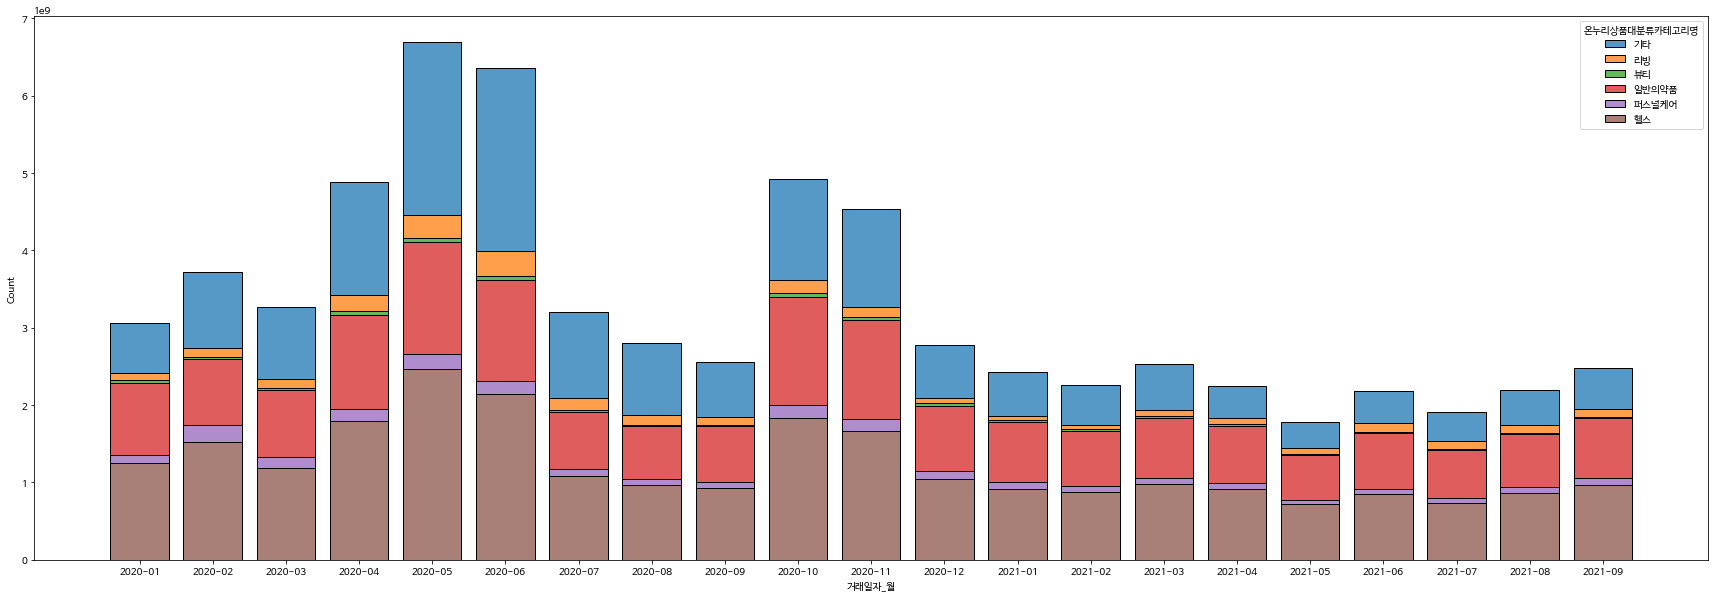

In [ ]:
plt.figure(figsize = (30,10))
# sns.barplot(data=new_group, x= '거래일자_월', y= '비율', ci = None, hue = '온누리상품대분류카테고리명')
sns.histplot(data=new_group, x= '거래일자_월',  weights='상품판매금액', hue='온누리상품대분류카테고리명' , multiple='stack', shrink=0.8)

In [ ]:
data[data['온누리상품대분류카테고리명'] == '기타']['구매상품명'].value_counts().head(10)

5000원      115662
3000원       82230
10000원      70704
4000원       67824
조제료         50998
1000원       47781
2000원       36558
공적마스크1매     30660
500원        29850
2500원       27960
Name: 구매상품명, dtype: int64

In [ ]:
table_2 = data.groupby(['거래일자_주', '온누리상품소분류카테고리명'])['상품판매수량', '상품판매금액'].sum()
table_2 = table_2.reset_index()

In [ ]:
table_3 = data.groupby(['거래일자_주'])['상품판매금액'].sum()
table_3 = table_3.reset_index()

In [ ]:
table_4 = data.groupby(['거래일자_주', '구매상품명'])['상품판매수량', '상품판매금액'].sum()
table_4 = table_4.reset_index()

In [ ]:
table_5 = data.groupby(['온누리상품소분류카테고리명'])['상품판매수량', '상품판매금액'].sum()
table_5 = table_5.reset_index()

In [ ]:
table_4_sort = table_4[table_4['온누리상품대분류카테고리명'] == '일반의약품'].sort_values(by='상품판매금액', ascending=False)

In [ ]:
table_4_sort.head(40)

온누리상품대분류카테고리명              구매상품명  상품판매수량     상품판매금액
20095         일반의약품         타이레놀정500mg  168493  439707062
19908         일반의약품        케토톱플라스타(덕용)   35959  375022100
17706         일반의약품            광동우황청심원   29330  273445556
20684         일반의약품              후시딘연고   46514  241899903
20270         일반의약품              판피린큐액   43959  232602078
17825         일반의약품            까스활명수큐액   50125  201129275
20259         일반의약품            판콜에스내복액   55605  188805657
18269         일반의약품           마데카솔케어연고   31212  166480030
20105         일반의약품             탁센연질캡슐   51614  151793830
17889         일반의약품              노스카나겔   10616  150275830
18688         일반의약품              비판텐연고   16627  148864251
19897         일반의약품        케토엑스투카타플라스마   34734  135735860
17651         일반의약품               게보린정   41486  133548439
19312         일반의약품          에이프록센연질캡슐   44454  132855400
18539         일반의약품            베나치오에프액   66342  129090860
18004         일반의약품              더블자임정   42573  125250946
17821         일반의약품              까스활명수   36592  122661518
20369         일반의약품            풀케어네일라카    3955  116205400
19864         일반의약품           카베진코와알파정    4875  109960460
17656         일반의약품            겔포스엠현탁액   27445  107875182
17714         일반의약품          광동우황청심원원방   11084  103676720
17729         일반의약품               광동원탕   40620  102501258
19568         일반의약품         이지엔6이브연질캡슐   33172   95687200
19748         일반의약품          젤존팝카타플라스마   32629   95014918
18066         일반의약품          둘코락스에스40정    9046   90925356
19302         일반의약품            에스빌연질캡슐   30331   88942555
20697         일반의약품            훼스탈플러스정   33821   88385000
19778         일반의약품               지르텍정   18859   88320300
18964         일반의약품         신신파스아렉스(대)   26209   84087422
19217         일반의약품            알러엔연질캡슐   27726   83089900
20093         일반의약품     타이레놀이알서방정650mg   38267   81596666
19954         일반의약품          코앤쿨나잘스프레이    8483   81420500
20197         일반의약품              트립라인정   32275   81058200
18041         일반의약품            동아 판피린큐   31016   77383704
19416         일반의약품             용각산파우더   11398   75973360
20061         일반의약품               클라펜정   30018   74594100
18325         일반의약품             맨소래담로션   10590   73134500
18160         일반의약품               러지텍정   35924   72815690
18027         일반의약품              도미나크림    1559   72497700
20382         일반의약품  프렌즈아이드롭점안액순(MILD)   14608   72461100

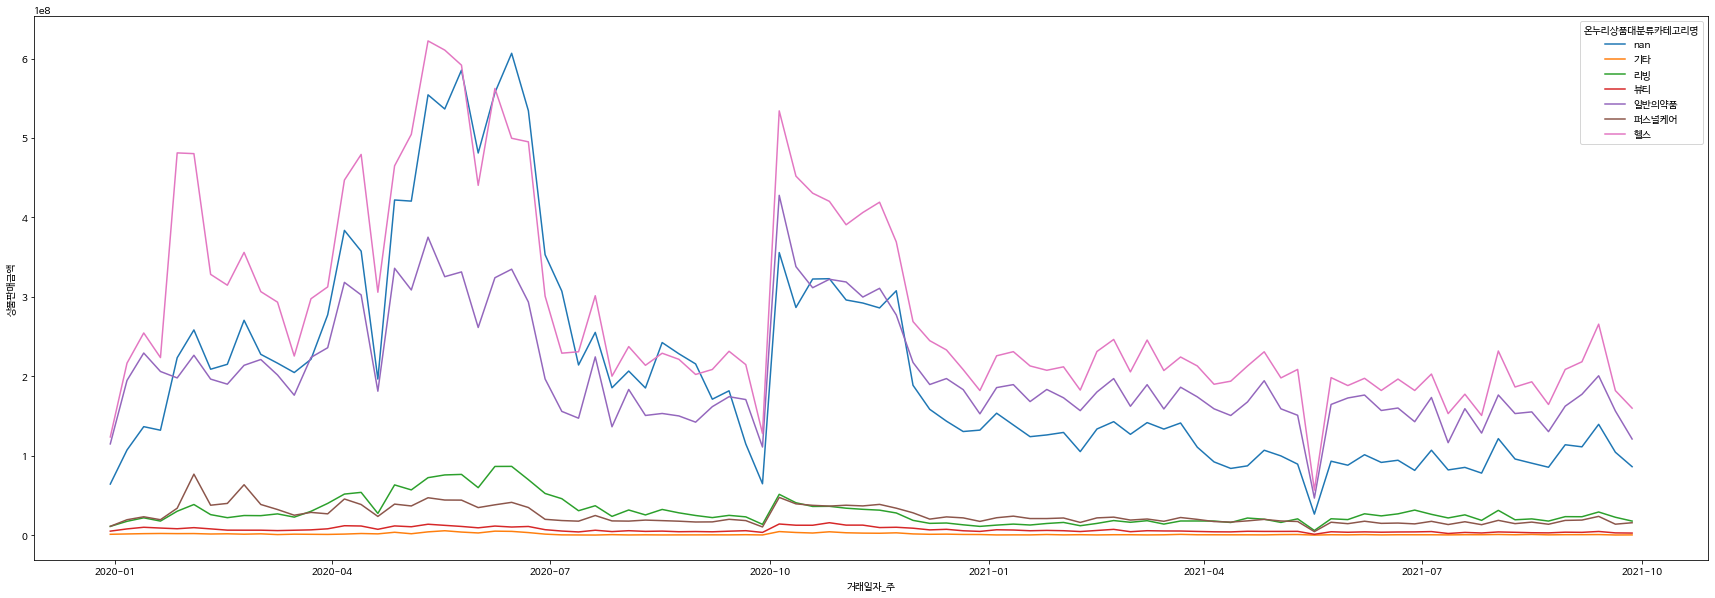

In [ ]:
plt.figure(figsize = (30,10))
sns.lineplot(data = table_2, x = '거래일자_주', y = '상품판매금액', ci = None, hue = '온누리상품대분류카테고리명')

In [ ]:
table_5.sort_values(by='상품판매금액', ascending=False).head(20)

온누리상품소분류카테고리명     상품판매수량       상품판매금액
73             미분류상품    3902784  17863812809
208  종합비타민/비타민B/비타민C     603180   5213002291
23            국소진통완화     685124   2777075929
32                기타     760535   2373595186
257            해열·진통     833806   2286173251
58               마스크  403098456   2183067789
192             잇몸건강     127281   1744578178
112         상처드레싱·밴드     594042   1672270081
168              유산균      36888   1250573278
196      자양강장 고농축앰플제     131339   1249497875
125               소화     410238   1141565970
207             종합감기     316462   1131701227
229         코감기/알레르기     298223   1123424003
5                간건강     168969   1014037009
163             오메가3      22020    973486620
167               위장     275934    904122834
71             무좀·진균      82520    845068693
111            상처/흉터     130678    809586017
183             인공눈물     127909    809269642
216        청심원/천왕보심단     129578    760592013

In [ ]:
temp = table_2[table_2['온누리상품소분류카테고리명'] == '종합비타민/비타민B/비타민C']
temp2 = table_2[table_2['온누리상품소분류카테고리명'] == '마스크']
# 종합감기
temp3 = table_2[table_2['온누리상품소분류카테고리명'] == '종합감기']
# 인공눈물	
temp4 = table_4[table_4['구매상품명'] == '타이레놀정500mg']

In [ ]:
temp

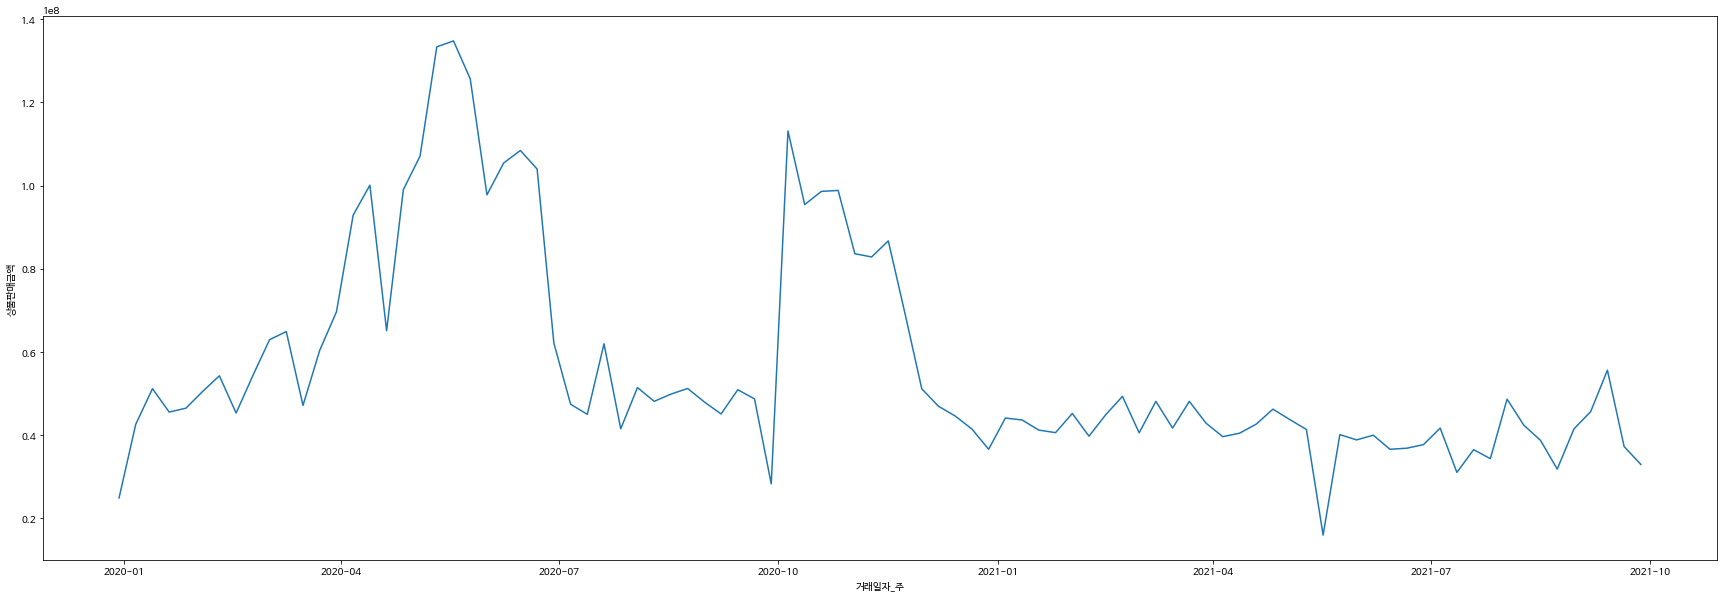

In [ ]:
plt.figure(figsize = (30,10))
sns.lineplot(data = temp, x = '거래일자_주', y = '상품판매금액',)

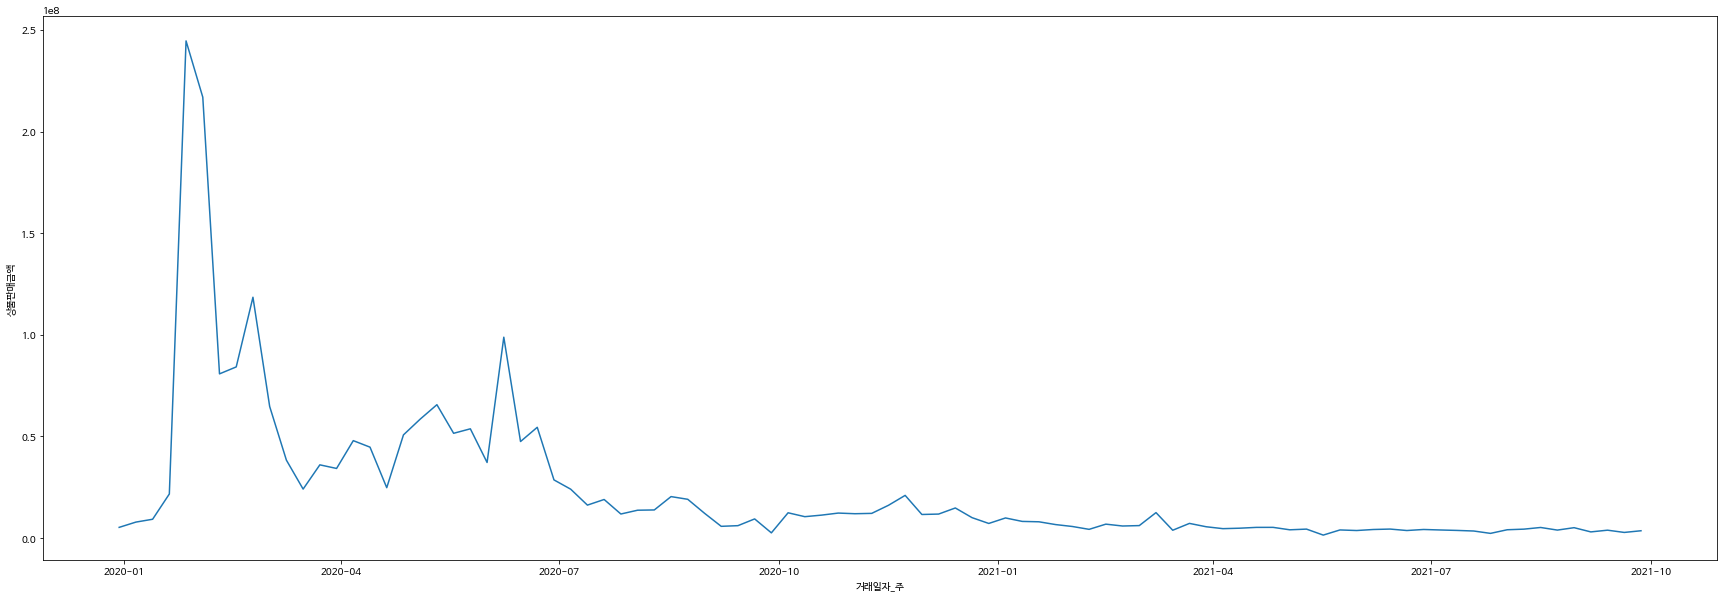

In [ ]:
plt.figure(figsize = (30,10))
sns.lineplot(data = temp2, x = '거래일자_주', y = '상품판매금액')

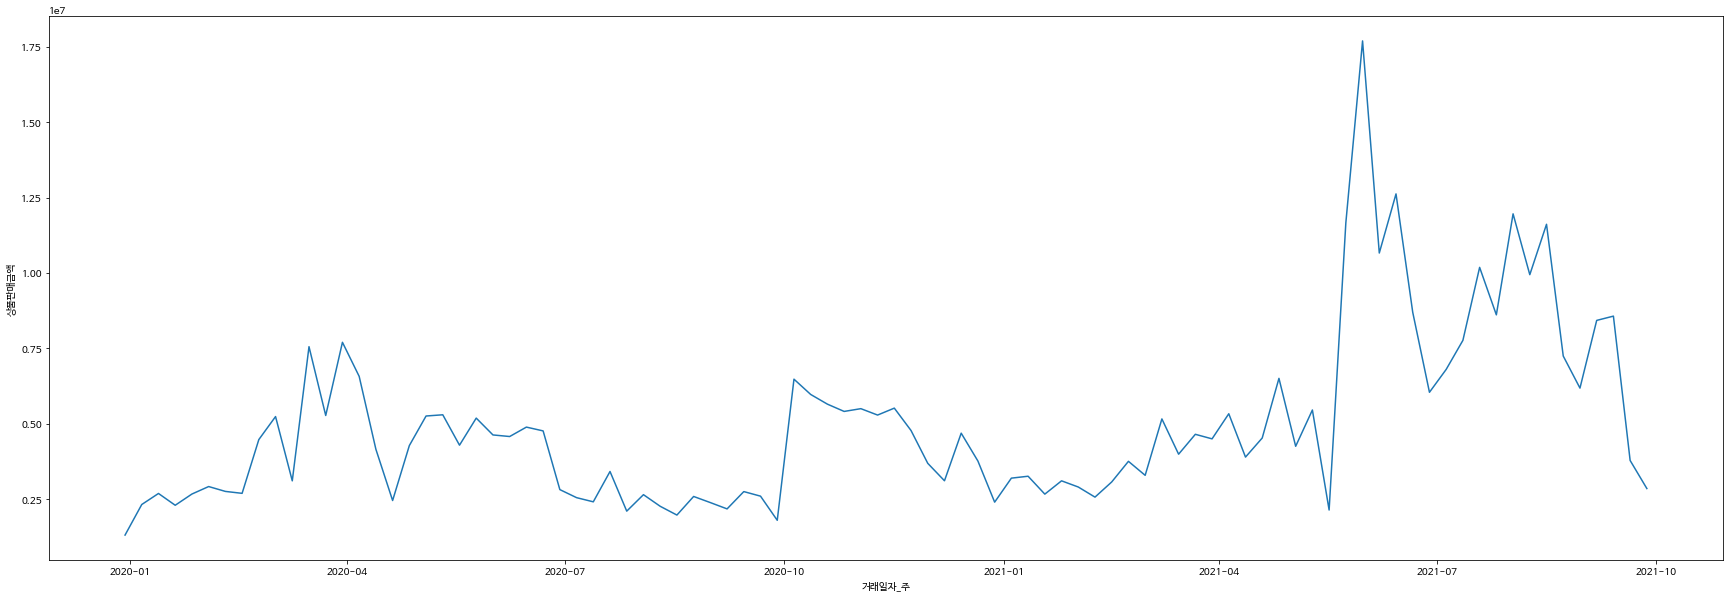

In [ ]:
plt.figure(figsize = (30,10))
sns.lineplot(data = temp4, x = '거래일자_주', y = '상품판매금액')

In [ ]:
data['온누리상품중분류카테고리명'].unique()

array([' 감기', ' 한방약', ' 해열/진통/소염/근이완', 'nan', ' 응급·구급처치', ' 피부외용약',
       ' 간건강', ' 피로/건강증진', ' 의료기기·용품', ' 자양강장', ' 소화/위장', ' 미용소품',
       ' 온누리약국 소모품(온누리H&C 배송)', ' 국소진통완화약', ' 안약', ' 더마케어', ' 오랄케어',
       ' 헬시푸드', ' 금연', ' 헤어케어(의약품포함)', ' 기타', ' 어린이건강', ' 발·다리케어',
       ' 바디/핸드케어', ' 생활용품', ' 아이케어', ' 혈행개선/혈관건강', ' 잇몸건강', ' 여성건강',
       ' 장건강', ' 당뇨·혈당건강', ' 가족계획', ' 다이어트', ' 애견용품', ' 뼈/관절건강', ' 스킨케어',
       ' 마사지/교정/운동용품', ' 수면유도약', ' 위생용품', ' 눈건강', ' 유아용품', ' 시니어용품',
       ' 드링크/음료/한방', ' 완구 및 캐릭터', ' 건강증진제품', ' 간/담도/소화기용제', ' 남성건강',
       ' 민감성피부관리(브랜드)', ' 온누리약국 소모품(공급사 직배송)', ' 피부외용제', ' 웰빙식품', ' 방충',
       ' 베이비케어', ' 립케어', '피로/건강증진', '응급·구급처치', '애견용품', '피부외용약', '오랄케어',
       '소화/위장', '감기', '혈행개선/혈관건강', '국소진통완화약', '더마케어', '해열/진통/소염/근이완',
       '한방약', '잇몸건강', '헬시푸드', '수면유도약', '안약', '자양강장', '발·다리케어', '간건강',
       '가족계획', '마사지/교정/운동용품', '의료기기·용품', '위생용품', '여성건강', '생활용품', '어린이건강',
       '기타', '미용소품', '아이케어', '눈건강', '헤어케어(의약품포함)', '바디/핸드케어',
       '온누리약국 소모품(공급사 직배송)'

In [ ]:
a['거래일자'] = a['거래일자'].astype('str')
a['거래일자'] = a['거래일자'].str.slice(stop=4) + '-' + a['거래일자'].str.slice(start=4, stop=6) + '-' + a['거래일자'].str.slice(start=6)
a['거래일자'] = pd.to_datetime(a['거래일자'])

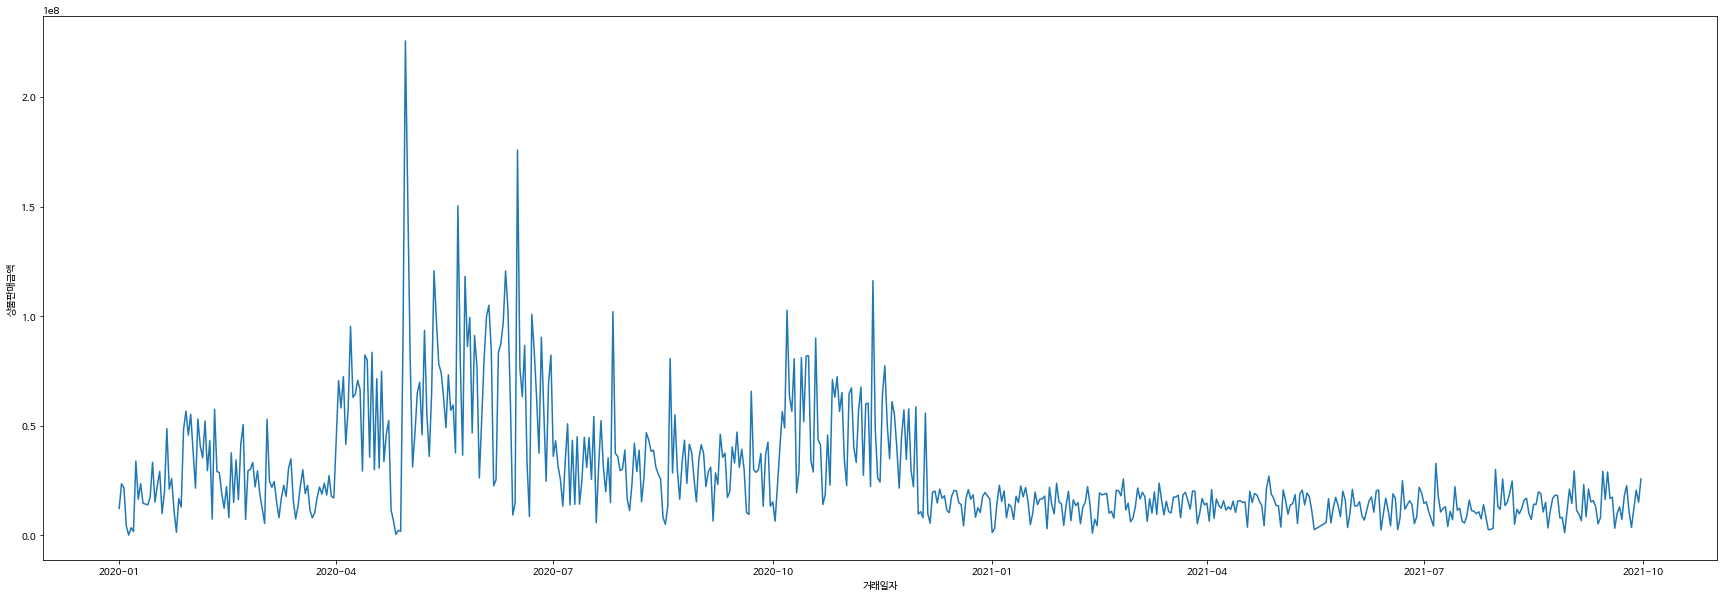

In [ ]:
plt.figure(figsize = (30,10))
sns.lineplot(data = a[a['온누리상품대분류카테고리명'] == '헬스'], x = '거래일자', y = '상품판매금액', ci=None)

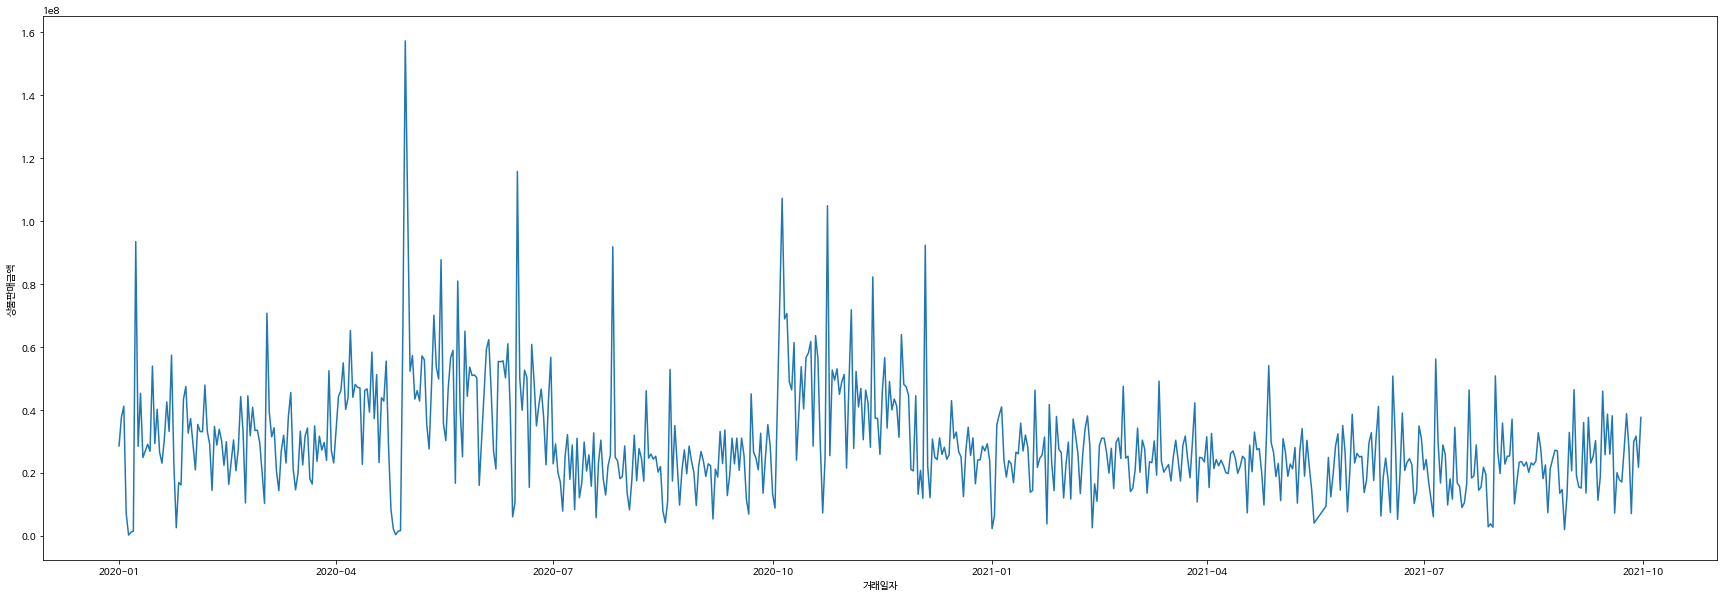

In [ ]:
plt.figure(figsize = (30,10))
sns.lineplot(data = a[a['온누리상품대분류카테고리명'] == '일반의약품'], x = '거래일자', y = '상품판매금액', ci=None)

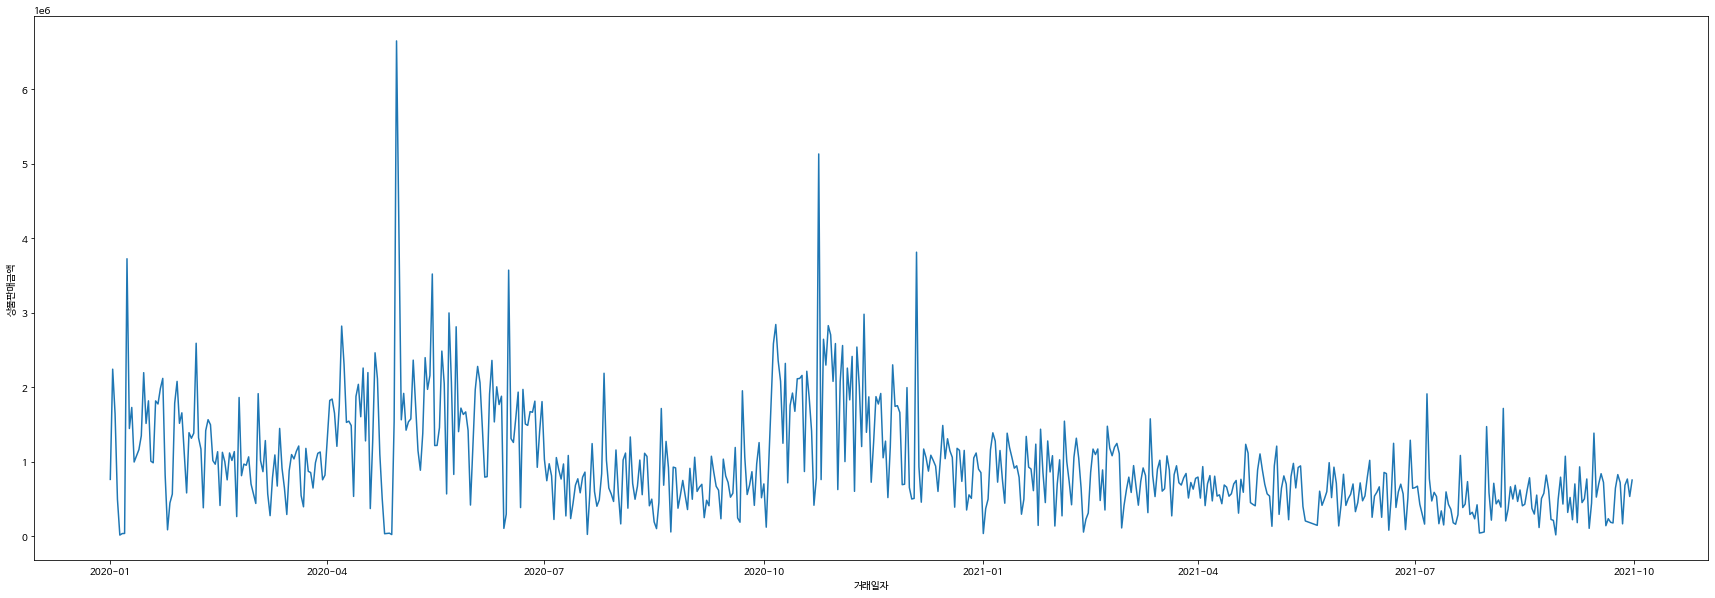

In [ ]:
plt.figure(figsize = (30,10))
sns.lineplot(data = a[a['온누리상품대분류카테고리명'] == '뷰티'], x = '거래일자', y = '상품판매금액', ci=None)

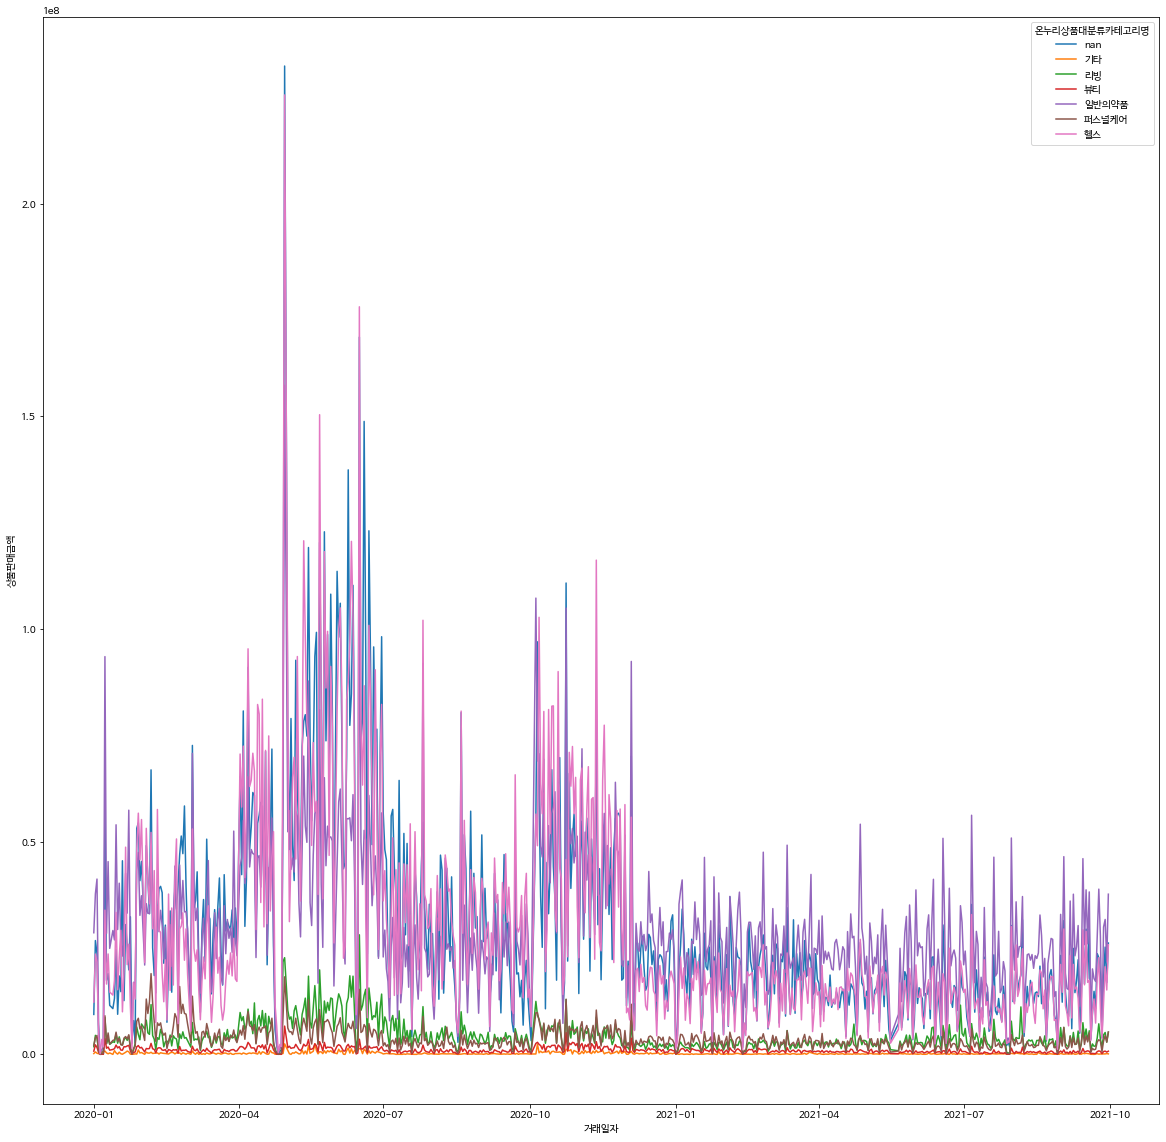

In [ ]:
plt.figure(figsize = (20,20))
sns.lineplot(data = a, x = '거래일자', y = '상품판매금액', ci=None, hue='온누리상품대분류카테고리명')

In [ ]:
data.groupby(['온누리상품대분류카테고리명', '거래일자'])['상품판매금액'].sum()

온누리상품대분류카테고리명                거래일자    
기타                           20201201      38000
                             20201202      24000
                             20201204     701500
                             20201205     184900
                             20201206      40000
                                          ...   
헬스(일부 카테고리에 일반의약품 포함) 한방건재   20200625    1000000
                             20200725     360000
                             20201006     440000
                             20201031     200000
                             20201126     500000
Name: 상품판매금액, Length: 4098, dtype: int64

In [ ]:
data.columns

Index(['거래일자', '우편번호', '시도명', '시군구명', '읍면동명', '온누리상품대분류카테고리명', '온누리상품중분류카테고리명', '온누리상품소분류카테고리명', '상품판매수량', '상품판매금액', '구매상품명'], dtype='object')

In [ ]:
data.groupby('r')

동아박카스D        183684
타이레놀정500mg    125490
5000원         115662
3000원          82230
10000원         70704
4000원          67824
조제료            50998
1000원          47781
후시딘연고          42636
텐텐츄정           41643
기타상품           40440
판콜에스내복액        39181
탁센연질캡슐         37774
베나치오에프액        37687
에이프록센연질캡슐      36645
2000원          36558
글루콤액           35672
까스활명수큐액        34444
더블자임정          32935
판피린큐액          30907
공적마스크1매        30660
Name: 구매상품명, dtype: int64

In [ ]:
# 이렇게 데이터 관리하지 마세욧!
data[data['구매상품명'] == '1000원']['읍면동명'].value_counts()

후평3동    47460
삼향면       321
Name: 읍면동명, dtype: int64

In [ ]:
data['온누리상품소분류카테고리명'].value_counts()

In [ ]:
temp = data[data['온누리상품소분류카테고리명'] == '종합비타민/비타민B/비타민C']['거래일자'].value_counts()

In [ ]:
temp = temp.sort_index()

In [ ]:
temp2 = temp.to_frame().reset_index()

In [ ]:
temp2.columns = ['거래일자', '판매량']

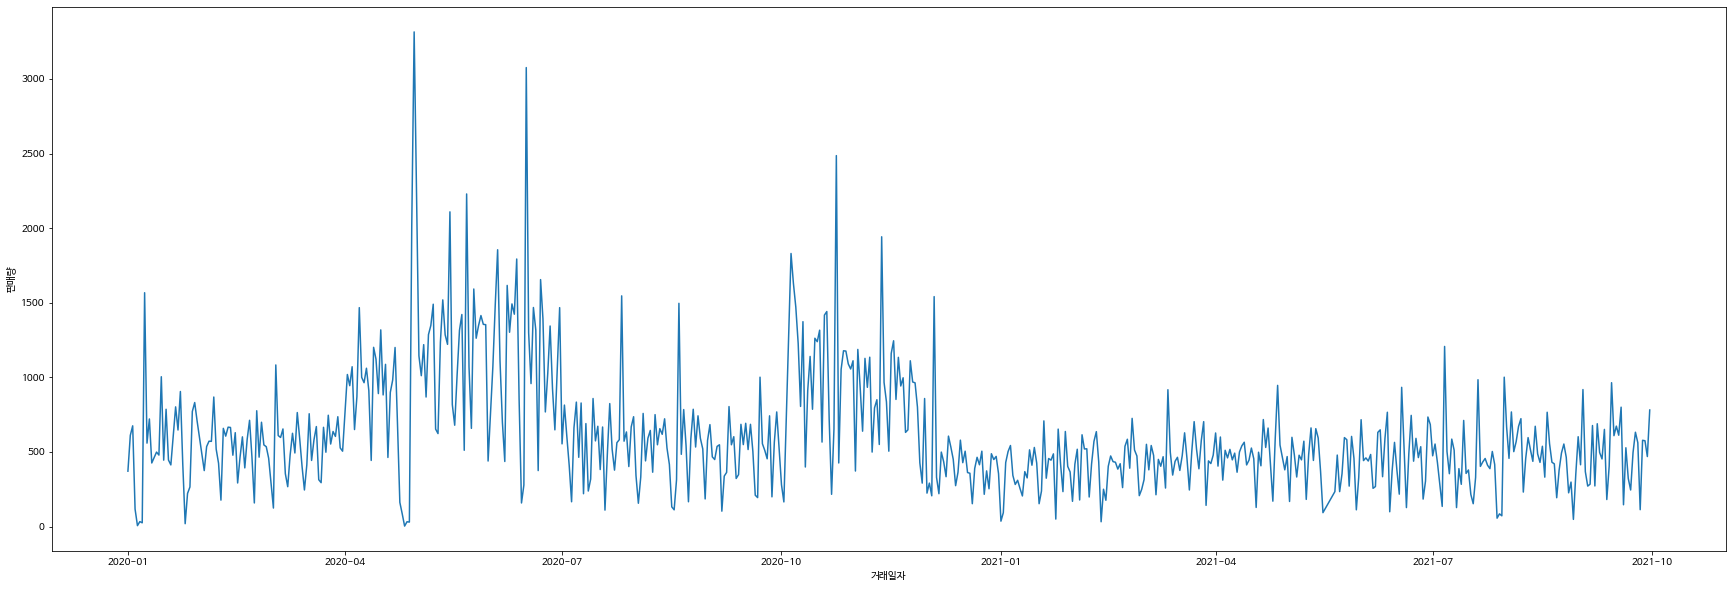

In [ ]:
plt.figure(figsize = (30,10))  
sns.lineplot(data = temp2, y= '판매량', x='거래일자')